In [1]:
%matplotlib inline
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import cv2, os, math, time, sys
from datetime import timedelta
from sklearn.utils import shuffle
sys.path.append('../../original_images')
from gen_data_batch import generate_batch, generate_batch_1

../../original_images/psvrt.py:3: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/Users/as186233/anaconda2/envs/py36/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/Users/as186233/anaconda2/envs/py36/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/as186233/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Users/as186233/anaconda2/envs/py36/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/Users/as186233/anaconda2/envs/py36/lib/python3.6/site-packages/ipykernel/kernelapp.py

In [15]:
def see_output_grey(iNp,depth_filter_to_see=0,cmap="gray",figsize=(4,4)):
    img_x = iNp[0,:,:]
    fig = plt.figure(figsize=figsize)
    plt.imshow(img_x, interpolation='none', aspect='auto')
#     plt.colorbar(img_x, orientation='horizontal')
    plt.show()


def see_output(iNp,depth_filter_to_see=0,cmap="gray",figsize=(4,4)):
    img_x = iNp[0,:,:,:]
    fig = plt.figure(figsize=figsize)
    if cmap == "gray":
        plt.imshow(img_x, cmap=plt.get_cmap('gray'))
    else:
        plt.imshow(img_x, interpolation='none', aspect='auto')
#     plt.colorbar(img_x, orientation='horizontal')
    plt.show()
    
def normalise(tensor):
    return tf.div(
   tf.subtract(
      tensor, 
      tf.reduce_min(tensor)
   ), 
   tf.subtract(
      tf.reduce_max(tensor), 
      tf.reduce_min(tensor)
   )
) 

def new_weights(shape, layer_name):
    initializer = tf.contrib.layers.xavier_initializer()
    return tf.Variable(initializer(shape), name=layer_name+'_W')

def new_bias(length, layer_name):
    return tf.Variable(tf.constant(0.05, shape=[length]), name=layer_name+'_b')

def new_conv_layer(input,
                   num_input_channels,
                   filter_size,
                   num_filters,
                   name_scope,
                   layer_name='',
                   use_pooling=True):

    with tf.name_scope(name_scope):
        shape = [filter_size, filter_size, num_input_channels, num_filters]
        weights = new_weights(shape, layer_name)
        biases = new_bias(num_filters, layer_name)

        layer = tf.add(tf.nn.conv2d(input=input, filter=weights, strides=[1,1,1,1], padding='SAME'), biases, name=layer_name)
#         print('layer:', layer)
        if use_pooling:
            layer = tf.nn.max_pool(value=layer,
                                   ksize=[1, 2, 2, 1],
                                   strides=[1, 2, 2, 1],
                                   padding='SAME', name=layer_name+'_max')
        layer = tf.nn.relu(layer, name=layer_name+'_activation')
        
#         print('maxpooled layer:', layer)
        
    return layer, weights

def flatten_layer(layer):
    layer_shape = layer.get_shape()
    num_features = layer_shape[1:4].num_elements()
    layer_flat = tf.reshape(layer, [-1, num_features])
    
    return layer_flat, num_features

def new_fc_layer(input,
                num_inputs,
                num_outputs,
                name_scope,
                layer_name='',
                use_relu=True):
    
    with tf.name_scope(name_scope):
        weights = new_weights([num_inputs, num_outputs], layer_name)
        biases = new_bias(num_outputs, layer_name)

        layer = tf.add(tf.matmul(input, weights),biases,name=layer_name)
    #     layer = tf.matmul(input, weights) + biases

        if use_relu:
            layer = tf.nn.relu(layer, layer_name+'_activation')
    
    return layer

def argmax_2d(tensor, bat_len):
    
    inp_tensor_shape = tf.shape(tensor)
    nimgs = inp_tensor_shape[0]
    img_dims = inp_tensor_shape[1:]
    img_len = inp_tensor_shape[-1]
    flat_img = tf.reshape(tensor, [-1, tf.reduce_prod(img_dims)])

    # # argmax of the flat tensor
    argmax_x = tf.map_fn(lambda img: tf.cast(tf.argmax(img), tf.float64) // tf.cast(img_len, dtype=tf.float64), tf.cast(flat_img, dtype=tf.float64))
    argmax_y = tf.map_fn(lambda img: tf.cast(tf.argmax(img), tf.float64) % tf.cast(img_len, dtype=tf.float64), tf.cast(flat_img, dtype=tf.float64))

    res = tf.stack([argmax_x, argmax_y, tf.zeros([bat_len], dtype=tf.float64)], axis = 1)
    
    return res

# def extract_patch(orig_vec, mask_vec):
#     batch_len = tf.shape(mask_vec)[0]
#     input_shape = (img_shape[0], img_shape[1])
#     rows, cols = input_shape[0], input_shape[1]
#     item_shape = tf.Variable([item_size[0], item_size[1]])
#     d_rows, d_cols = item_shape[0], item_shape[1]
#     subm_rows, subm_cols = rows - d_rows + 1, cols - d_cols + 1

#     ii, jj = tf.meshgrid(tf.range(d_rows), tf.range(d_cols), indexing='ij')
#     d_ii, d_jj = tf.meshgrid(tf.range(subm_rows), tf.range(subm_cols), indexing='ij')

#     subm_ii = ii[:subm_rows, :subm_cols, tf.newaxis, tf.newaxis] + d_ii
#     subm_jj = jj[:subm_rows, :subm_cols, tf.newaxis, tf.newaxis] + d_jj

#     subm_st = tf.stack([subm_ii, subm_jj], axis=-1)

#     gather_exp = tf.map_fn(lambda mask: tf.gather_nd(mask, subm_st), mask_vec)

#     subm_dims = tf.shape(gather_exp)
#     gather_exp = tf.reshape(gather_exp, [-1,  subm_dims[1] * subm_dims[2], subm_dims[3], subm_dims[4]])
#     reduced_mat = tf.map_fn(lambda mask: tf.scan(lambda a, b: tf.multiply(a, b), tf.squeeze(mask))[-1], gather_exp)
#     pred_crds = argmax_2d(reduced_mat, batch_len)
    
#     pred_crds = tf.cast(pred_crds, dtype = tf.int64)
    
#     itms = tf.map_fn(lambda idx: tf.cast(tf.slice(orig_vec[tf.cast(idx, tf.int64), :, :, :],pred_crds[tf.cast(idx, tf.int64), :], [item_size[0],item_size[1], 3]), dtype = tf.float64), tf.cast(tf.range(batch_len), dtype = tf.float64))
# #     itms = tf.map_fn(lambda idx: tf.cast(tf.slice(tf.squeeze(vec[idx:idx+1, :, :]), tf.squeeze(pred_crds[idx:idx+1, :]), [item_size[0], item_size[1]]), dtype=tf.int32), tf.range(batch_len))
    
#     return itms


def extract_patch(orig_vec, mask_vec):
    batch_len = tf.shape(mask_vec)[0]
    input_shape = (img_shape[0], img_shape[1])
    rows, cols = input_shape[0], input_shape[1]
    item_shape = tf.Variable([item_size[0], item_size[1]])
    d_rows, d_cols = item_shape[0], item_shape[1]
    subm_rows, subm_cols = rows - d_rows + 1, cols - d_cols + 1

    ii, jj = tf.meshgrid(tf.range(d_rows), tf.range(d_cols), indexing='ij')
    d_ii, d_jj = tf.meshgrid(tf.range(subm_rows), tf.range(subm_cols), indexing='ij')

    subm_ii = ii[:subm_rows, :subm_cols, tf.newaxis, tf.newaxis] + d_ii
    subm_jj = jj[:subm_rows, :subm_cols, tf.newaxis, tf.newaxis] + d_jj

    subm_st = tf.stack([subm_ii, subm_jj], axis=-1)

    gather_exp = tf.map_fn(lambda mask: tf.gather_nd(mask, subm_st), mask_vec)

    subm_dims = tf.shape(gather_exp)
    gather_exp = tf.reshape(gather_exp, [-1,  subm_dims[1] * subm_dims[2], subm_dims[3], subm_dims[4]])
    reduced_mat = tf.map_fn(lambda mask: tf.scan(lambda a, b: tf.multiply(a, b), tf.squeeze(mask))[-1], gather_exp)
    pred_crds = argmax_2d(reduced_mat, batch_len)
    
    pred_crds = tf.cast(pred_crds, dtype = tf.int64, name= "predicted_crds")
    
    itms = tf.map_fn(lambda idx: tf.cast(tf.slice(orig_vec[tf.cast(idx, tf.int64), :, :, :],pred_crds[tf.cast(idx, tf.int64), :], [item_size[0],item_size[1], 3]), dtype = tf.float64), tf.cast(tf.range(batch_len), dtype = tf.float64))
#     itms = tf.map_fn(lambda idx: tf.cast(tf.slice(tf.squeeze(vec[idx:idx+1, :, :]), tf.squeeze(pred_crds[idx:idx+1, :]), [item_size[0], item_size[1]]), dtype=tf.int32), tf.range(batch_len))
    
    return itms

def restore_see_layer(orig, input_name, model_name=None, var_name=None):
    result = []
    with tf.Session('', tf.Graph()) as s:
        with s.graph.as_default():
            if ((model_name != None) and var_name != None):
                saver = tf.train.import_meta_graph(model_name+".meta")
                saver.restore(s, model_name)
                fd = {input_name +':0': orig}
#                 print(fd.shape)
                for var in var_name:
                    var=var+":0"
#                     result = 0

                    result.append(s.run(var, feed_dict=fd))
    return result[0] 

def test_mask_sd(batch_size, model_mask_sd): 
    np.set_printoptions(suppress=True)
    sd_accuracy = 0.
    mask_accuracy = 0.
    sig_mask_accuracy = 0.
    
    test_set, mask_test_labels, test_labels = generate_batch_1(batch_size, img_shape, item_size, nitems) 
    
#     mask_logits,  sd = restore_see_layer(orig=test_set, input_name = 'x', model_name=model_mask_sd, var_name=['train_mask/mask_6/fc3', 'mask_sd/mask_conv_layer/sd_y_pred'])
    mask_logits = restore_see_layer(orig=test_set, input_name = 'x', model_name=model_mask_sd, var_name=['train_mask/sigmoid_output'])

#     mask_logits[mask_logits < 0 ] = 0
    
#     print('Predicted Mask Logits: ', mask_logits[0].shape)
#     print('Predicted Mask: ', pred_mask.shape)
#     print('Original Mask: ', mask_test_labels)
#     print('Test SD: ', test_set)

#     sd_accuracy = np.sum(np.argmax(sd, axis=1) == np.argmax(test_labels, axis=1))/batch_size

#     cor_prd_imgs = np.sum([True for pm, tm  in zip(pred_mask, mask_test_labels) if np.allclose(pm, tm)])    
#     sig_cor_prd_imgs = np.sum([True for pm, tm  in zip(pred_mask, mask_test_labels) if np.allclose(pm, tm)])    

#     print(cor_prd_imgs)
#     mask_accuracy = cor_prd_imgs/batch_size
#     sig_mask_accuracy = sig_cor_prd_imgs/batch_size
    
#     print('Mask Test Accuracy:{0:>.4f}, Sigmoid Test Accuracy:{1:>.4f}'.format(mask_accuracy, sig_mask_accuracy))

#     print('Mask Test Accuracy:{0:>.4f}, SD Test Accuracy:{1:>.4f}'.format(mask_accuracy, sd_accuracy))
    

    
    return test_set, mask_accuracy, sd_accuracy, mask_logits, mask_test_labels


def sigmoid(x, derivative=False):
    sigm = 1. / (1. + np.exp(-x))
    if derivative:
        return sigm * (1. - sigm)
    return sigm

def plotNNFilter(units):
    print(units.shape)
    filters = units.shape[3]
    plt.figure(1, figsize=(20,20))
    n_columns = 6
    n_rows = math.ceil(filters / n_columns) + 1
    for i in range(filters):
        plt.subplot(n_rows, n_columns, i+1)
        plt.title('Filter ' + str(i))
        plt.imshow(units[0,:,:,i], interpolation="nearest")
        

def getActivations(layer, feed_dict_train):
    with tf.Session() as session:
        session.run(tf.global_variables_initializer())
        units = session.run(layer, feed_dict=feed_dict_train)
    
        plotNNFilter(units)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


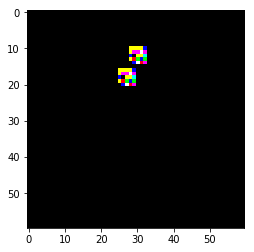

(1, 30, 30, 8)


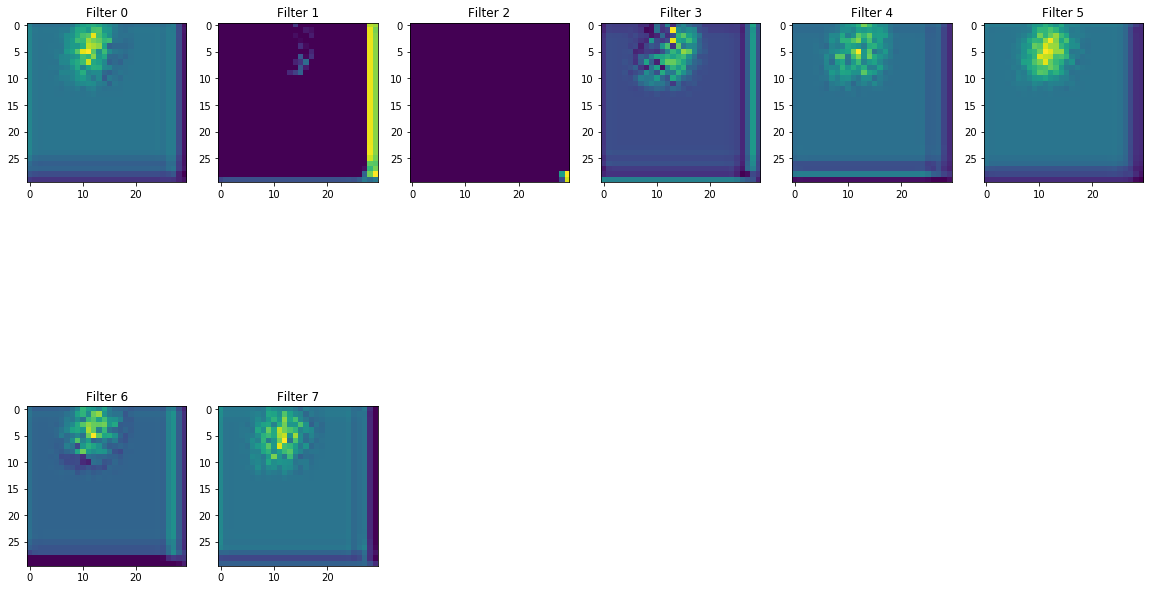

In [36]:
test_bat = 1

# train_data, mask_labels, labels = generate_batch_1(test_bat, img_shape, item_size, nitems) 

feed_dict_train = {x: train_data,
           mask_y_true: mask_labels}

see_output(np.reshape(train_data, [test_bat, img_shape[0], img_shape[1], img_shape[2]]))

# with tf.Session() as session:
#     session.run(tf.global_variables_initializer())
#     units = session.run(num_features, feed_dict=feed_dict_train)

# print(m_num_features)
# getActivations(mask_layer0_conv0, feed_dict_train)
# print("******")
# getActivations(mask_layer1_conv1, feed_dict_train)
# print("******")
# getActivations(mask_layer2_conv2, feed_dict_train)
# print("******")
# getActivations(mask_layer3_conv3, feed_dict_train)
# getActivations(mask_layer4_conv4, feed_dict_train)
getActivations(mask_layer5_conv5, feed_dict_train)
# getActivations(mask_layer_fc3, feed_dict_train)

INFO:tensorflow:Restoring parameters from SD/single_patch_model.ckpt


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[[0.50034755 0.49966216 0.49809155 ... 0.50087494 0.50515777 0.4978991 ]
  [0.5049458  0.5023939  0.50236374 ... 0.50144565 0.5013706  0.49722138]
  [0.5004614  0.50267357 0.50075746 ... 0.5163366  0.5184139  0.50684977]
  ...
  [0.50136715 0.49920928 0.49609435 ... 0.5081254  0.4999745  0.49942026]
  [0.5007623  0.49960026 0.5011958  ... 0.49647802 0.4996775  0.49740854]
  [0.49423075 0.49752724 0.49893084 ... 0.50327164 0.50375026 0.50430167]]]


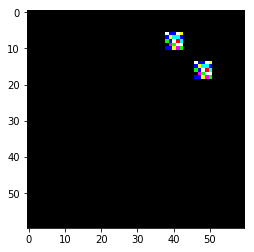

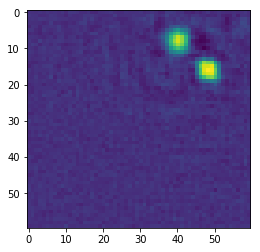

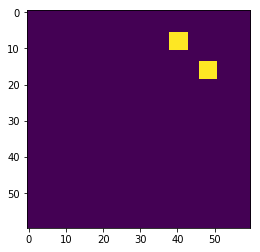

In [28]:
test_bat = 1
# test_set, mask_test_labels, test_labels = generate_batch_1(test_bat, img_shape, item_size, nitems) 
# orig_img = np.reshape(test_set, [test_bat, img_shape[0], img_shape[1], img_shape[2]])

# resh_mask_test_lbls = np.reshape(mask_test_labels, [test_bat, img_shape[0], img_shape[1]])

# see_output(orig_img, figsize=(4,4))
# see_output_grey(resh_mask_test_lbls, figsize = (4,4))

orig_img, mask_acc, pred_crds, mask_logits, mask_test_lbls = test_mask_sd(test_bat, single_patch_model)
resh_mask_test_lbls = np.reshape(mask_test_lbls, [test_bat, img_shape[0], img_shape[1]])
resh_orig_img = np.reshape(orig_img, [test_bat, img_shape[0], img_shape[1], img_shape[2]])

resh_logits = np.reshape(mask_logits, [test_bat, img_shape[0], img_shape[1]])
# resh_mask = np.reshape(mask, [test_bat, img_shape[0], img_shape[1]])

print(resh_logits)
# print(list(resh_mask))
# print(pred_crds)
# print(resh_mask[0].shape)
# print(resh_mask_test_lbls)

# print(np.array_equal(np.squeeze(resh_mask[0])), np.squeeze(np.flatten(resh_mask_test_lbls[0]))))

# resh_logits[resh_logits < 0] = 0
see_output(resh_orig_img)
see_output_grey(resh_logits)

# see_output_grey(resh_mask, figsize=(8,8))
see_output_grey(resh_mask_test_lbls)


# resh_mask_test_lbls
# img_x = iNp[0,:,:]
# fig = plt.figure(figsize=(8,8))
# plt.imshow(np.squeeze(resh_mask_test_lbls), interpolation='none', aspect='auto')
#     plt.colorbar(img_x, orientation='horizontal')
# plt.show()

In [3]:
single_patch_model = "SD/single_patch_model.ckpt"
total_imgs = 50000
train_batch_size = 64
img_shape = (60,60,3)
item_size = (5,5)
nitems = 2
num_classes = 2

In [4]:
# Placeholders
x = tf.placeholder(tf.float32, shape=[None, img_shape[0]*img_shape[1]*img_shape[2]], name='x')
x_image = tf.reshape(x, [-1, img_shape[0], img_shape[1], img_shape[2]])

mask_y_true = tf.placeholder(tf.float32, shape=[None, img_shape[0] * img_shape[1]], name='mask_y_true')
mask_y_true_cls = tf.argmax(mask_y_true, axis=1) 

sd_y_true = tf.placeholder(tf.float32, shape=[None, 2], name='sd_y_true')
sd_y_true_cls = tf.argmax(sd_y_true, axis=1)        

initializer = tf.contrib.layers.xavier_initializer()

name_scope = 'train_mask'

# mask_graph layer configurations
# mask_graph layer configurations
m_filter_size0 = 6          # Convolution filters(kernel) are 4 x 4 pixels.
m_num_filters0 = 10         # There are 16 of these filters.

m_filter_size1 = 6          # Convolution filters are 4 x 4 pixels.
m_num_filters1 = 10         # There are 16 of these filters.

# Convolutional Layer 2.
m_filter_size2 = 4          # Convolution filters are 2 x 2 pixels.
m_num_filters2 = 16         # There are 16 of these filters.

m_filter_size3 = 4          # Convolution filters are 2 x 2 pixels.
m_num_filters3 = 8         # There are 4 of these filters.

# Convolutional Layer 3.
m_filter_size4 = 2          # Convolution filters are 2 x 2 pixels.
m_num_filters4 = 8         # There are 32 of these filters.

m_filter_size5 = 2          # Convolution filters are 2 x 2 pixels.
m_num_filters5 = 8         # There are 16 of these filters.


# Fully-connected layer.
m_fc_size = 2000             # Number of neurons in fully-connected layer.


"""SD Network Layer Architecture"""
filter_size1 = 4          # Convolution filters are 4 x 4 pixels.
num_filters1 = 16         # There are 16 of these filters.

# Convolutional Layer 2.
filter_size2 = 2          # Convolution filters are 2 x 2 pixels.
num_filters2 = 32         # There are 32 of these filters.

# Convolutional Layer 3.
filter_size3 = 2          # Convolution filters are 2 x 2 pixels.
num_filters3 = 64         # There are 64 of these filters.

# Convolutional Layer 4.
filter_size4 = 2          # Convolution filters are 2 x 2 pixels.
num_filters4 = 128         # There are 128 of these filters.

# Fully-connected layer.
fc_size = 256             # Number of neurons in fully-connected layer.

with tf.name_scope(name_scope):
# First Convolution Layer
    layer_name = 'mask_conv_layer'
    shape = [m_filter_size0, m_filter_size0, img_shape[2], m_num_filters0]
    mask_weights = tf.Variable(initializer(shape), name=layer_name+'_W')  
    mask_biases = tf.Variable(tf.constant(0.05, shape=[m_num_filters0]), name=layer_name+'_b')

    mask_layer0_conv0, weights_conv0 = new_conv_layer(input=x_image,
                                                num_input_channels=img_shape[2],
                                                filter_size=m_filter_size0,
                                                num_filters=m_num_filters0,
                                                 name_scope = 'mask',
                                                 layer_name = 'conv1',
                                                use_pooling=False)
#     layer0_conv0_drpout = tf.nn.dropout(layer0_conv0, 0.3, name="drop_out")

    mask_layer1_conv1, weights_conv1 = new_conv_layer(input=mask_layer0_conv0,
                                                num_input_channels=m_num_filters0,
                                                filter_size=m_filter_size1,
                                                num_filters=m_num_filters1,
                                                 name_scope = 'mask',
                                                 layer_name = 'conv2',
                                                use_pooling=False)

#     layer1_conv1_drpout = tf.nn.dropout(layer1_conv1, 0.3, name="drop_out")

    mask_layer2_conv2, weights_conv2 =  new_conv_layer(input=mask_layer1_conv1,
                                               num_input_channels=m_num_filters1,
                                               filter_size=m_filter_size2,
                                               num_filters=m_num_filters2,
                                                 name_scope = 'mask',
                                                 layer_name = 'conv3',
                                               use_pooling=True)

    mask_layer3_conv3, weights_conv3 =  new_conv_layer(input=mask_layer2_conv2,
                                               num_input_channels=m_num_filters2,
                                               filter_size=m_filter_size3,
                                               num_filters=m_num_filters3,
                                                 name_scope = 'mask',
                                                 layer_name = 'conv4',
                                               use_pooling=False)

    mask_layer4_conv4, weights_conv4 =  new_conv_layer(input=mask_layer3_conv3,
                                               num_input_channels=m_num_filters3,
                                               filter_size=m_filter_size4,
                                               num_filters=m_num_filters4,
                                                 name_scope = 'mask',
                                                 layer_name = 'conv5',
                                               use_pooling=False)


    mask_layer5_conv5, weights_conv5 =  new_conv_layer(input=mask_layer4_conv4,
                                               num_input_channels=m_num_filters4,
                                               filter_size=m_filter_size5,
                                               num_filters=m_num_filters5,
                                                 name_scope = 'mask',
                                                 layer_name = 'conv6',
                                               use_pooling=False)
    
#     layer6_conv6, weights_conv6 =  new_conv_layer(input=layer5_conv5,
#                                            num_input_channels=m_num_filters5,
#                                            filter_size=m_filter_size6,
#                                            num_filters=m_num_filters6,
#                                              name_scope = 'mask',
#                                              layer_name = 'conv7',
#                                            use_pooling=True)

    m_layer_flat, m_num_features = flatten_layer(mask_layer5_conv5)
#     print(layer_flat)
#     layer_fc1 = new_fc_layer(input=layer_flat,
#                              num_inputs=num_features,
#                              num_outputs=m_fc_size,
#                              name_scope = 'mask',
#                              layer_name = 'fc1',
#                              use_relu=False)
#     print('layer_fc1:', layer_fc1)
#     layer_fc2 = new_fc_layer(input=layer_fc1,
#                              num_inputs=m_fc_size,
#                              num_outputs=m_fc_size,
#                              name_scope = 'mask',
#                              layer_name = 'fc2',
#                              use_relu=False)

#     layer_fc3 = new_fc_layer(input=layer_fc2,
#                              num_inputs=m_fc_size,
#                              num_outputs=m_fc_size,
#                              name_scope = 'mask',
#                              layer_name = 'fc3',
#                              use_relu=False)
#     mask_drop_out = tf.nn.dropout(layer_fc3, 0.5, name="drop_out")

    mask_layer_fc3 = new_fc_layer(input=m_layer_flat,
                             num_inputs=m_num_features,
                             num_outputs=img_shape[0] * img_shape[1],
                             name_scope = 'mask',
                             layer_name = 'fc3',
                             use_relu=False)

#     mask_drop_out = tf.nn.dropout(mask_layer_fc4, 0.5, name="drop_out")
#     y_pred = tf.nn.softmax(mask_drop_out, name="softmax_output")
    y_pred = mask_layer_fc3
    
    # round numbers less than 0.5 to zero;
    # by making them negative and taking the maximum with 0
#     differentiable_round = tf.maximum(y_pred-0.499,0)
    # scale the remaining numbers (0 to 0.5) to greater than 1
    # the other half (zeros) is not affected by multiplication
#     differentiable_round = differentiable_round * 10000
    # take the minimum with 1
#     y_pred_round = tf.minimum(differentiable_round, 1)
#     print(differentiable_round)

    y_pred_sigmoid = tf.nn.sigmoid(y_pred, name="sigmoid_output")
    y_pred_sigmoid = tf.reshape(y_pred_sigmoid, [-1, img_shape[0], img_shape[1]])
    
    batch_len = tf.shape(y_pred_sigmoid)[0]
    input_shape = (img_shape[0], img_shape[1])
    rows, cols = input_shape[0], input_shape[1]
    item_shape = tf.Variable([item_size[0], item_size[1]])
    d_rows, d_cols = item_shape[0], item_shape[1]
    subm_rows, subm_cols = rows - d_rows + 1, cols - d_cols + 1

    ii, jj = tf.meshgrid(tf.range(d_rows), tf.range(d_cols), indexing='ij')
    d_ii, d_jj = tf.meshgrid(tf.range(subm_rows), tf.range(subm_cols), indexing='ij')

    subm_ii = ii[:subm_rows, :subm_cols, tf.newaxis, tf.newaxis] + d_ii
    subm_jj = jj[:subm_rows, :subm_cols, tf.newaxis, tf.newaxis] + d_jj

    subm_st = tf.stack([subm_ii, subm_jj], axis=-1)
    
    gather_exp = tf.map_fn(lambda mask: tf.gather_nd(mask, subm_st), y_pred_sigmoid)

    subm_dims = tf.shape(gather_exp)
    gather_exp = tf.reshape(gather_exp, [-1,  subm_dims[1] * subm_dims[2], subm_dims[3], subm_dims[4]])
    reduced_mat = tf.map_fn(lambda mask: tf.scan(lambda a, b: tf.multiply(a, b), tf.squeeze(mask))[-1], gather_exp)
    
    inp_tensor_shape = tf.shape(reduced_mat)
    nimgs = inp_tensor_shape[0]
    img_dims = inp_tensor_shape[1:]
    img_len = inp_tensor_shape[-1]
    flat_img = tf.reshape(reduced_mat, [-1, tf.reduce_prod(img_dims)])

    _, top_idx = tf.nn.top_k(flat_img, nitems)
    topx_idx = tf.squeeze(tf.cast(tf.reshape(top_idx, [-1, 1]), tf.float32) // tf.cast(img_len, tf.float32))
    topy_idx = tf.squeeze(tf.cast(tf.reshape(top_idx, [-1, 1]), tf.float32) % tf.cast(img_len, tf.float32))
    
    res12 = tf.stack([topx_idx, topy_idx, tf.zeros([batch_len * nitems], dtype=tf.float32)], axis = 1, name= "pred_crds12")    
    
    pred_crds12 = tf.cast(res12, dtype = tf.int32, name= "predicted_crds12") 
    pred_crds = tf.map_fn(lambda idx: pred_crds12[idx: idx + 2], tf.range(0, batch_len * nitems, nitems), dtype = tf.int32)
   
  
    items = tf.map_fn(lambda img_idx: tf.reshape(tf.map_fn(lambda itm_idx: tf.slice(x_image[img_idx, :, :, :],
                                                      pred_crds[img_idx, itm_idx, :], 
                                                      [item_size[0],item_size[1], 3])
                                               , tf.range(nitems), dtype = tf.float32), 
                                                [item_size[0] * 2, item_size[0], 3])
                         , tf.range(batch_len), dtype = tf.float32)

    mask_loss = tf.square(mask_y_true - y_pred)
    mask_cost = tf.reduce_mean(mask_loss)
    
    train_op1 = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(mask_loss)
    
    ### some more performance measures
    mask_correct_prediction = tf.equal(y_pred, mask_y_true)
    mask_accuracy = tf.reduce_mean(tf.cast(mask_correct_prediction, tf.float32))        

# name_scope = 'mask_sd'
# with tf.name_scope(name_scope):

#     input_sd = tf.cast(items, dtype = tf.float32, name=layer_name + "/input_sd")
    
#     layer1_conv1, weights_conv1 = new_conv_layer(input=input_sd,
#                                                 num_input_channels=img_shape[2],
#                                                 filter_size=filter_size1,
#                                                 num_filters=num_filters1,
#                                                  name_scope = 'mask_sd_graph',
#                                                  layer_name = 'conv1',
#                                                 use_pooling=True)

#     layer2_conv2, weights_conv2 = new_conv_layer(input=layer1_conv1,
#                                                 num_input_channels=num_filters1,
#                                                 filter_size=filter_size2,
#                                                 num_filters=num_filters2,
#                                                  name_scope = 'mask_sd_graph',
#                                                  layer_name = 'conv2',
#                                                 use_pooling=True)

#     layer3_conv3, weights_conv3 =  new_conv_layer(input=layer2_conv2,
#                                                num_input_channels=num_filters2,
#                                                filter_size=filter_size3,
#                                                num_filters=num_filters3,
#                                                  name_scope = 'mask_sd_graph',
#                                                  layer_name = 'conv3',
#                                                use_pooling=True)

#     layer4_conv4, weights_conv4 =  new_conv_layer(input=layer3_conv3,
#                                                num_input_channels=num_filters3,
#                                                filter_size=filter_size4,
#                                                num_filters=num_filters4,
#                                                  name_scope = 'mask_sd_graph',
#                                                  layer_name = 'conv4',
#                                                use_pooling=True)

#     layer_flat, num_features = flatten_layer(layer4_conv4)       

#     layer_fc1 = new_fc_layer(input=layer_flat,
#                      num_inputs=num_features,
#                      num_outputs=fc_size,
#                      name_scope = 'mask_sd_graph',
#                      layer_name = 'fc1',
#                      use_relu=True)

#     layer_fc2 = new_fc_layer(input=layer_fc1,
#                              num_inputs=fc_size,
#                              num_outputs=fc_size,
#                              name_scope = 'mask_sd_graph',
#                              layer_name = 'fc2',
#                              use_relu=False)

#     layer_fc3 = new_fc_layer(input=layer_fc2,
#                              num_inputs=fc_size,
#                              num_outputs=fc_size,
#                              name_scope = 'mask_sd_graph',
#                              layer_name = 'fc3',
#                              use_relu=False)

#     layer_fc4 = new_fc_layer(input=layer_fc3,
#                              num_inputs=fc_size,
#                              num_outputs=num_classes,
#                              name_scope = 'mask_sd_graph',
#                              layer_name = 'fc4',
#                              use_relu=False)


    
    
#     sd_y_pred = tf.nn.softmax(layer_fc4, name=layer_name + "/sd_y_pred")
#     sd_y_pred_cls = tf.argmax(sd_y_pred, axis=1)
    
#     sd_loss = tf.nn.softmax_cross_entropy_with_logits_v2(logits=sd_y_pred, labels=sd_y_true)
    
#     train_op1 = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(mask_loss)
#     train_op2 = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(sd_loss)
#     final_train_op = tf.group(train_op1, train_op2)    

#     sd_cost = tf.reduce_mean(sd_loss)
    
#     sd_correct_prediction = tf.equal(sd_y_pred_cls, sd_y_true_cls)
#     sd_accuracy = tf.reduce_mean(tf.cast(sd_correct_prediction, tf.float32))        
    

In [5]:
def optimize(num_epochs, save_model=True,save_name= "base_model",restore_model=False,restore_name=None):
    total_iterations = 0
    done_train_imgs = 0
    start_time = time.time()
    start_batch=0
    end_batch = train_batch_size
    test_batch_size = 256
    plot_accuracy=[]
    plot_accuracy_epoch=[]
    plot_training_size=[]
    plot_training_size_epoch=[]
    plot_mask = []
    plot_mask_sd = []
    plot_sd = []
    plot_sr = []
    saver = tf.train.Saver()
    
    sum_accuracy = 0.0
    n = 1

    session = tf.Session()         
    session.run(tf.global_variables_initializer())
    
            #to save the model
    for i in range(0, num_epochs):   
        start_batch=0
        end_batch = train_batch_size

        print("Epoch:", i + 1)

        if restore_model==True:
            if restore_name==None:
                print("No model file specified")
                return
            else:
                saver.restore(session,restore_name)

        sum_accuracy = 0.0
        n = 1
        while end_batch < total_imgs:

            train_data, mask_labels, labels = generate_batch_1(train_batch_size, img_shape, item_size, nitems) 
#             print(train_data.shape)
#             print(train_data[0])
            if not len(train_data) and not len(labels) and not len(mask_labels):
                print("All images have been processed.")
                break;

#             feed_dict_train = {x: train_data,
#                        mask_y_true: mask_labels,
#                               sd_y_true: labels}

            feed_dict_train = {x: train_data,
                       mask_y_true: mask_labels}

            session.run(train_op1, feed_dict=feed_dict_train)

#             session.run(final_train_op, feed_dict=feed_dict_train)
#             mask_acc, mask_co, sd_acc, sd_co = session.run([mask_accuracy, mask_cost, sd_correct_prediction, sd_cost], feed_dict=feed_dict_train)            
#             msg = "Optimization Iteration: {0:>6}, Mask Training Accuracy: {1:>6.1%}, Mask Loss: {2:>.4f}, SD Training Accuracy: {1:>6.1%}, SD Loss: {2:>.4f}"
#             print(msg.format(end_batch + 1, mask_acc, mask_co, sd_acc, sd_co))

            mask_acc, mask_co, itms = session.run([mask_accuracy, mask_cost, items], feed_dict=feed_dict_train)            
            msg = "Optimization Iteration: {0:>6}, Mask Training Accuracy: {1:>6.1%}, Mask Loss: {2:>.4f}"
            print(msg.format(end_batch + 1, mask_acc, mask_co))

#             print(list(train_data[0]))
#             print('Predicted Cords: ', list(pred_crd))

#             fig=plt.figure(figsize=(8, 8))
#             columns = 8
#             rows = 8
#             for i in range(1, columns*rows):
#                 img = itms[i]
#                 fig.add_subplot(rows, columns, i)
#                 plt.imshow(img)
#             plt.show()            
            
            start_batch += train_batch_size
            end_batch += train_batch_size
        if save_model==True:
            if save_name==None:
                print("No model specified, model not being saved")
                return
            else:
                save_path = saver.save(session, save_name)
                restore_model = True
                print("Model saved in file: %s" % save_name)
    
#         s_time = time.time()                    
#         mask_acc, sd_acc, _, _ = test_mask_sd(test_batch_size, save_name)
#         plot_mask.append(mask_acc)
#         plot_sd.append(sd_acc)
#         e_time = time.time()
#         time_dif = e_time - s_time
#         print("Test Mask SD Time usage: " + str(timedelta(seconds=int(round(time_dif)))))  

    end_time = time.time()
    time_dif = end_time - start_time

    # Print the time-usage.
    print("Time usage: " + str(timedelta(seconds=int(round(time_dif))))) 
    print('plot mask accuracy:')
    print(plot_mask)
    print(plot_sd)


In [6]:
save_model = True
save_name = single_patch_model
restore_model=False
restore_name=single_patch_model
optimize(num_epochs=5, save_model=True,save_name=single_patch_model,restore_model=restore_model,restore_name=single_patch_model)




Epoch: 1
Optimization Iteration:     65, Mask Training Accuracy:   0.0%, Mask Loss: 0.0232


../../original_images/psvrt.py:253: RuntimeWarning: divide by zero encountered in long_scalars
  running_orientation += np.arctan(y / x)


Optimization Iteration:    129, Mask Training Accuracy:   0.0%, Mask Loss: 0.0182
Optimization Iteration:    193, Mask Training Accuracy:   0.0%, Mask Loss: 0.0164
Optimization Iteration:    257, Mask Training Accuracy:   0.0%, Mask Loss: 0.0162
Optimization Iteration:    321, Mask Training Accuracy:   0.0%, Mask Loss: 0.0163
Optimization Iteration:    385, Mask Training Accuracy:   0.0%, Mask Loss: 0.0165
Optimization Iteration:    449, Mask Training Accuracy:   0.0%, Mask Loss: 0.0165
Optimization Iteration:    513, Mask Training Accuracy:   0.0%, Mask Loss: 0.0163
Optimization Iteration:    577, Mask Training Accuracy:   0.0%, Mask Loss: 0.0161
Optimization Iteration:    641, Mask Training Accuracy:   0.0%, Mask Loss: 0.0159
Optimization Iteration:    705, Mask Training Accuracy:   0.0%, Mask Loss: 0.0157
Optimization Iteration:    769, Mask Training Accuracy:   0.0%, Mask Loss: 0.0154
Optimization Iteration:    833, Mask Training Accuracy:   0.0%, Mask Loss: 0.0152
Optimization Ite

Optimization Iteration:   6529, Mask Training Accuracy:   0.0%, Mask Loss: 0.0133
Optimization Iteration:   6593, Mask Training Accuracy:   0.0%, Mask Loss: 0.0132
Optimization Iteration:   6657, Mask Training Accuracy:   0.0%, Mask Loss: 0.0132
Optimization Iteration:   6721, Mask Training Accuracy:   0.0%, Mask Loss: 0.0132
Optimization Iteration:   6785, Mask Training Accuracy:   0.0%, Mask Loss: 0.0132
Optimization Iteration:   6849, Mask Training Accuracy:   0.0%, Mask Loss: 0.0132
Optimization Iteration:   6913, Mask Training Accuracy:   0.0%, Mask Loss: 0.0131
Optimization Iteration:   6977, Mask Training Accuracy:   0.0%, Mask Loss: 0.0131
Optimization Iteration:   7041, Mask Training Accuracy:   0.0%, Mask Loss: 0.0131
Optimization Iteration:   7105, Mask Training Accuracy:   0.0%, Mask Loss: 0.0131
Optimization Iteration:   7169, Mask Training Accuracy:   0.0%, Mask Loss: 0.0131
Optimization Iteration:   7233, Mask Training Accuracy:   0.0%, Mask Loss: 0.0130
Optimization Ite

Optimization Iteration:  12929, Mask Training Accuracy:   0.0%, Mask Loss: 0.0117
Optimization Iteration:  12993, Mask Training Accuracy:   0.0%, Mask Loss: 0.0115
Optimization Iteration:  13057, Mask Training Accuracy:   0.0%, Mask Loss: 0.0116
Optimization Iteration:  13121, Mask Training Accuracy:   0.0%, Mask Loss: 0.0115
Optimization Iteration:  13185, Mask Training Accuracy:   0.0%, Mask Loss: 0.0115
Optimization Iteration:  13249, Mask Training Accuracy:   0.0%, Mask Loss: 0.0116
Optimization Iteration:  13313, Mask Training Accuracy:   0.0%, Mask Loss: 0.0115
Optimization Iteration:  13377, Mask Training Accuracy:   0.0%, Mask Loss: 0.0115
Optimization Iteration:  13441, Mask Training Accuracy:   0.0%, Mask Loss: 0.0115
Optimization Iteration:  13505, Mask Training Accuracy:   0.0%, Mask Loss: 0.0114
Optimization Iteration:  13569, Mask Training Accuracy:   0.0%, Mask Loss: 0.0114
Optimization Iteration:  13633, Mask Training Accuracy:   0.0%, Mask Loss: 0.0115
Optimization Ite

Optimization Iteration:  19329, Mask Training Accuracy:   0.0%, Mask Loss: 0.0102
Optimization Iteration:  19393, Mask Training Accuracy:   0.0%, Mask Loss: 0.0102
Optimization Iteration:  19457, Mask Training Accuracy:   0.0%, Mask Loss: 0.0102
Optimization Iteration:  19521, Mask Training Accuracy:   0.0%, Mask Loss: 0.0102
Optimization Iteration:  19585, Mask Training Accuracy:   0.0%, Mask Loss: 0.0103
Optimization Iteration:  19649, Mask Training Accuracy:   0.0%, Mask Loss: 0.0101
Optimization Iteration:  19713, Mask Training Accuracy:   0.0%, Mask Loss: 0.0101
Optimization Iteration:  19777, Mask Training Accuracy:   0.0%, Mask Loss: 0.0101
Optimization Iteration:  19841, Mask Training Accuracy:   0.0%, Mask Loss: 0.0100
Optimization Iteration:  19905, Mask Training Accuracy:   0.0%, Mask Loss: 0.0102
Optimization Iteration:  19969, Mask Training Accuracy:   0.0%, Mask Loss: 0.0102
Optimization Iteration:  20033, Mask Training Accuracy:   0.0%, Mask Loss: 0.0101
Optimization Ite

Optimization Iteration:  25729, Mask Training Accuracy:   0.0%, Mask Loss: 0.0089
Optimization Iteration:  25793, Mask Training Accuracy:   0.0%, Mask Loss: 0.0090
Optimization Iteration:  25857, Mask Training Accuracy:   0.0%, Mask Loss: 0.0089
Optimization Iteration:  25921, Mask Training Accuracy:   0.0%, Mask Loss: 0.0090
Optimization Iteration:  25985, Mask Training Accuracy:   0.0%, Mask Loss: 0.0089
Optimization Iteration:  26049, Mask Training Accuracy:   0.0%, Mask Loss: 0.0087
Optimization Iteration:  26113, Mask Training Accuracy:   0.0%, Mask Loss: 0.0088
Optimization Iteration:  26177, Mask Training Accuracy:   0.0%, Mask Loss: 0.0089
Optimization Iteration:  26241, Mask Training Accuracy:   0.0%, Mask Loss: 0.0089
Optimization Iteration:  26305, Mask Training Accuracy:   0.0%, Mask Loss: 0.0088
Optimization Iteration:  26369, Mask Training Accuracy:   0.0%, Mask Loss: 0.0089
Optimization Iteration:  26433, Mask Training Accuracy:   0.0%, Mask Loss: 0.0089
Optimization Ite

Optimization Iteration:  32129, Mask Training Accuracy:   0.0%, Mask Loss: 0.0078
Optimization Iteration:  32193, Mask Training Accuracy:   0.0%, Mask Loss: 0.0079
Optimization Iteration:  32257, Mask Training Accuracy:   0.0%, Mask Loss: 0.0079
Optimization Iteration:  32321, Mask Training Accuracy:   0.0%, Mask Loss: 0.0078
Optimization Iteration:  32385, Mask Training Accuracy:   0.0%, Mask Loss: 0.0078
Optimization Iteration:  32449, Mask Training Accuracy:   0.0%, Mask Loss: 0.0078
Optimization Iteration:  32513, Mask Training Accuracy:   0.0%, Mask Loss: 0.0079
Optimization Iteration:  32577, Mask Training Accuracy:   0.0%, Mask Loss: 0.0078
Optimization Iteration:  32641, Mask Training Accuracy:   0.0%, Mask Loss: 0.0078
Optimization Iteration:  32705, Mask Training Accuracy:   0.0%, Mask Loss: 0.0078
Optimization Iteration:  32769, Mask Training Accuracy:   0.0%, Mask Loss: 0.0079
Optimization Iteration:  32833, Mask Training Accuracy:   0.0%, Mask Loss: 0.0078
Optimization Ite

Optimization Iteration:  38529, Mask Training Accuracy:   0.0%, Mask Loss: 0.0070
Optimization Iteration:  38593, Mask Training Accuracy:   0.0%, Mask Loss: 0.0069
Optimization Iteration:  38657, Mask Training Accuracy:   0.0%, Mask Loss: 0.0067
Optimization Iteration:  38721, Mask Training Accuracy:   0.0%, Mask Loss: 0.0068
Optimization Iteration:  38785, Mask Training Accuracy:   0.0%, Mask Loss: 0.0069
Optimization Iteration:  38849, Mask Training Accuracy:   0.0%, Mask Loss: 0.0069
Optimization Iteration:  38913, Mask Training Accuracy:   0.0%, Mask Loss: 0.0068
Optimization Iteration:  38977, Mask Training Accuracy:   0.0%, Mask Loss: 0.0068
Optimization Iteration:  39041, Mask Training Accuracy:   0.0%, Mask Loss: 0.0068
Optimization Iteration:  39105, Mask Training Accuracy:   0.0%, Mask Loss: 0.0069
Optimization Iteration:  39169, Mask Training Accuracy:   0.0%, Mask Loss: 0.0070
Optimization Iteration:  39233, Mask Training Accuracy:   0.0%, Mask Loss: 0.0069
Optimization Ite

Optimization Iteration:  44929, Mask Training Accuracy:   0.0%, Mask Loss: 0.0062
Optimization Iteration:  44993, Mask Training Accuracy:   0.0%, Mask Loss: 0.0063
Optimization Iteration:  45057, Mask Training Accuracy:   0.0%, Mask Loss: 0.0060
Optimization Iteration:  45121, Mask Training Accuracy:   0.0%, Mask Loss: 0.0061
Optimization Iteration:  45185, Mask Training Accuracy:   0.0%, Mask Loss: 0.0059
Optimization Iteration:  45249, Mask Training Accuracy:   0.0%, Mask Loss: 0.0061
Optimization Iteration:  45313, Mask Training Accuracy:   0.0%, Mask Loss: 0.0060
Optimization Iteration:  45377, Mask Training Accuracy:   0.0%, Mask Loss: 0.0062
Optimization Iteration:  45441, Mask Training Accuracy:   0.0%, Mask Loss: 0.0059
Optimization Iteration:  45505, Mask Training Accuracy:   0.0%, Mask Loss: 0.0059
Optimization Iteration:  45569, Mask Training Accuracy:   0.0%, Mask Loss: 0.0061
Optimization Iteration:  45633, Mask Training Accuracy:   0.0%, Mask Loss: 0.0061
Optimization Ite

Optimization Iteration:   1281, Mask Training Accuracy:   0.0%, Mask Loss: 0.0053
Optimization Iteration:   1345, Mask Training Accuracy:   0.0%, Mask Loss: 0.0056
Optimization Iteration:   1409, Mask Training Accuracy:   0.0%, Mask Loss: 0.0055
Optimization Iteration:   1473, Mask Training Accuracy:   0.0%, Mask Loss: 0.0053
Optimization Iteration:   1537, Mask Training Accuracy:   0.0%, Mask Loss: 0.0054
Optimization Iteration:   1601, Mask Training Accuracy:   0.0%, Mask Loss: 0.0053
Optimization Iteration:   1665, Mask Training Accuracy:   0.0%, Mask Loss: 0.0056
Optimization Iteration:   1729, Mask Training Accuracy:   0.0%, Mask Loss: 0.0055
Optimization Iteration:   1793, Mask Training Accuracy:   0.0%, Mask Loss: 0.0055
Optimization Iteration:   1857, Mask Training Accuracy:   0.0%, Mask Loss: 0.0056
Optimization Iteration:   1921, Mask Training Accuracy:   0.0%, Mask Loss: 0.0056
Optimization Iteration:   1985, Mask Training Accuracy:   0.0%, Mask Loss: 0.0054
Optimization Ite

Optimization Iteration:   7681, Mask Training Accuracy:   0.0%, Mask Loss: 0.0050
Optimization Iteration:   7745, Mask Training Accuracy:   0.0%, Mask Loss: 0.0051
Optimization Iteration:   7809, Mask Training Accuracy:   0.0%, Mask Loss: 0.0050
Optimization Iteration:   7873, Mask Training Accuracy:   0.0%, Mask Loss: 0.0052
Optimization Iteration:   7937, Mask Training Accuracy:   0.0%, Mask Loss: 0.0049
Optimization Iteration:   8001, Mask Training Accuracy:   0.0%, Mask Loss: 0.0051
Optimization Iteration:   8065, Mask Training Accuracy:   0.0%, Mask Loss: 0.0048
Optimization Iteration:   8129, Mask Training Accuracy:   0.0%, Mask Loss: 0.0048
Optimization Iteration:   8193, Mask Training Accuracy:   0.0%, Mask Loss: 0.0049
Optimization Iteration:   8257, Mask Training Accuracy:   0.0%, Mask Loss: 0.0051
Optimization Iteration:   8321, Mask Training Accuracy:   0.0%, Mask Loss: 0.0050
Optimization Iteration:   8385, Mask Training Accuracy:   0.0%, Mask Loss: 0.0049
Optimization Ite

Optimization Iteration:  14081, Mask Training Accuracy:   0.0%, Mask Loss: 0.0046
Optimization Iteration:  14145, Mask Training Accuracy:   0.0%, Mask Loss: 0.0046
Optimization Iteration:  14209, Mask Training Accuracy:   0.0%, Mask Loss: 0.0047
Optimization Iteration:  14273, Mask Training Accuracy:   0.0%, Mask Loss: 0.0047
Optimization Iteration:  14337, Mask Training Accuracy:   0.0%, Mask Loss: 0.0046
Optimization Iteration:  14401, Mask Training Accuracy:   0.0%, Mask Loss: 0.0048
Optimization Iteration:  14465, Mask Training Accuracy:   0.0%, Mask Loss: 0.0047
Optimization Iteration:  14529, Mask Training Accuracy:   0.0%, Mask Loss: 0.0045
Optimization Iteration:  14593, Mask Training Accuracy:   0.0%, Mask Loss: 0.0045
Optimization Iteration:  14657, Mask Training Accuracy:   0.0%, Mask Loss: 0.0046
Optimization Iteration:  14721, Mask Training Accuracy:   0.0%, Mask Loss: 0.0045
Optimization Iteration:  14785, Mask Training Accuracy:   0.0%, Mask Loss: 0.0046
Optimization Ite

Optimization Iteration:  20481, Mask Training Accuracy:   0.0%, Mask Loss: 0.0044
Optimization Iteration:  20545, Mask Training Accuracy:   0.0%, Mask Loss: 0.0044
Optimization Iteration:  20609, Mask Training Accuracy:   0.0%, Mask Loss: 0.0044
Optimization Iteration:  20673, Mask Training Accuracy:   0.0%, Mask Loss: 0.0041
Optimization Iteration:  20737, Mask Training Accuracy:   0.0%, Mask Loss: 0.0045
Optimization Iteration:  20801, Mask Training Accuracy:   0.0%, Mask Loss: 0.0045
Optimization Iteration:  20865, Mask Training Accuracy:   0.0%, Mask Loss: 0.0043
Optimization Iteration:  20929, Mask Training Accuracy:   0.0%, Mask Loss: 0.0044
Optimization Iteration:  20993, Mask Training Accuracy:   0.0%, Mask Loss: 0.0041
Optimization Iteration:  21057, Mask Training Accuracy:   0.0%, Mask Loss: 0.0044
Optimization Iteration:  21121, Mask Training Accuracy:   0.0%, Mask Loss: 0.0044
Optimization Iteration:  21185, Mask Training Accuracy:   0.0%, Mask Loss: 0.0043
Optimization Ite

Optimization Iteration:  26881, Mask Training Accuracy:   0.0%, Mask Loss: 0.0041
Optimization Iteration:  26945, Mask Training Accuracy:   0.0%, Mask Loss: 0.0042
Optimization Iteration:  27009, Mask Training Accuracy:   0.0%, Mask Loss: 0.0042
Optimization Iteration:  27073, Mask Training Accuracy:   0.0%, Mask Loss: 0.0041
Optimization Iteration:  27137, Mask Training Accuracy:   0.0%, Mask Loss: 0.0042
Optimization Iteration:  27201, Mask Training Accuracy:   0.0%, Mask Loss: 0.0042
Optimization Iteration:  27265, Mask Training Accuracy:   0.0%, Mask Loss: 0.0041
Optimization Iteration:  27329, Mask Training Accuracy:   0.0%, Mask Loss: 0.0043
Optimization Iteration:  27393, Mask Training Accuracy:   0.0%, Mask Loss: 0.0042
Optimization Iteration:  27457, Mask Training Accuracy:   0.0%, Mask Loss: 0.0040
Optimization Iteration:  27521, Mask Training Accuracy:   0.0%, Mask Loss: 0.0040
Optimization Iteration:  27585, Mask Training Accuracy:   0.0%, Mask Loss: 0.0042
Optimization Ite

Optimization Iteration:  33281, Mask Training Accuracy:   0.0%, Mask Loss: 0.0040
Optimization Iteration:  33345, Mask Training Accuracy:   0.0%, Mask Loss: 0.0041
Optimization Iteration:  33409, Mask Training Accuracy:   0.0%, Mask Loss: 0.0040
Optimization Iteration:  33473, Mask Training Accuracy:   0.0%, Mask Loss: 0.0038
Optimization Iteration:  33537, Mask Training Accuracy:   0.0%, Mask Loss: 0.0039
Optimization Iteration:  33601, Mask Training Accuracy:   0.0%, Mask Loss: 0.0042
Optimization Iteration:  33665, Mask Training Accuracy:   0.0%, Mask Loss: 0.0040
Optimization Iteration:  33729, Mask Training Accuracy:   0.0%, Mask Loss: 0.0040
Optimization Iteration:  33793, Mask Training Accuracy:   0.0%, Mask Loss: 0.0040
Optimization Iteration:  33857, Mask Training Accuracy:   0.0%, Mask Loss: 0.0040
Optimization Iteration:  33921, Mask Training Accuracy:   0.0%, Mask Loss: 0.0039
Optimization Iteration:  33985, Mask Training Accuracy:   0.0%, Mask Loss: 0.0038
Optimization Ite

Optimization Iteration:  39681, Mask Training Accuracy:   0.0%, Mask Loss: 0.0038
Optimization Iteration:  39745, Mask Training Accuracy:   0.0%, Mask Loss: 0.0039
Optimization Iteration:  39809, Mask Training Accuracy:   0.0%, Mask Loss: 0.0037
Optimization Iteration:  39873, Mask Training Accuracy:   0.0%, Mask Loss: 0.0038
Optimization Iteration:  39937, Mask Training Accuracy:   0.0%, Mask Loss: 0.0037
Optimization Iteration:  40001, Mask Training Accuracy:   0.0%, Mask Loss: 0.0039
Optimization Iteration:  40065, Mask Training Accuracy:   0.0%, Mask Loss: 0.0038
Optimization Iteration:  40129, Mask Training Accuracy:   0.0%, Mask Loss: 0.0038
Optimization Iteration:  40193, Mask Training Accuracy:   0.0%, Mask Loss: 0.0038
Optimization Iteration:  40257, Mask Training Accuracy:   0.0%, Mask Loss: 0.0037
Optimization Iteration:  40321, Mask Training Accuracy:   0.0%, Mask Loss: 0.0037
Optimization Iteration:  40385, Mask Training Accuracy:   0.0%, Mask Loss: 0.0039
Optimization Ite

Optimization Iteration:  46081, Mask Training Accuracy:   0.0%, Mask Loss: 0.0036
Optimization Iteration:  46145, Mask Training Accuracy:   0.0%, Mask Loss: 0.0037
Optimization Iteration:  46209, Mask Training Accuracy:   0.0%, Mask Loss: 0.0039
Optimization Iteration:  46273, Mask Training Accuracy:   0.0%, Mask Loss: 0.0039
Optimization Iteration:  46337, Mask Training Accuracy:   0.0%, Mask Loss: 0.0037
Optimization Iteration:  46401, Mask Training Accuracy:   0.0%, Mask Loss: 0.0038
Optimization Iteration:  46465, Mask Training Accuracy:   0.0%, Mask Loss: 0.0035
Optimization Iteration:  46529, Mask Training Accuracy:   0.0%, Mask Loss: 0.0036
Optimization Iteration:  46593, Mask Training Accuracy:   0.0%, Mask Loss: 0.0037
Optimization Iteration:  46657, Mask Training Accuracy:   0.0%, Mask Loss: 0.0035
Optimization Iteration:  46721, Mask Training Accuracy:   0.0%, Mask Loss: 0.0037
Optimization Iteration:  46785, Mask Training Accuracy:   0.0%, Mask Loss: 0.0036
Optimization Ite

Optimization Iteration:   2433, Mask Training Accuracy:   0.0%, Mask Loss: 0.0034
Optimization Iteration:   2497, Mask Training Accuracy:   0.0%, Mask Loss: 0.0037
Optimization Iteration:   2561, Mask Training Accuracy:   0.0%, Mask Loss: 0.0035
Optimization Iteration:   2625, Mask Training Accuracy:   0.0%, Mask Loss: 0.0036
Optimization Iteration:   2689, Mask Training Accuracy:   0.0%, Mask Loss: 0.0034
Optimization Iteration:   2753, Mask Training Accuracy:   0.0%, Mask Loss: 0.0035
Optimization Iteration:   2817, Mask Training Accuracy:   0.0%, Mask Loss: 0.0035
Optimization Iteration:   2881, Mask Training Accuracy:   0.0%, Mask Loss: 0.0035
Optimization Iteration:   2945, Mask Training Accuracy:   0.0%, Mask Loss: 0.0036
Optimization Iteration:   3009, Mask Training Accuracy:   0.0%, Mask Loss: 0.0034
Optimization Iteration:   3073, Mask Training Accuracy:   0.0%, Mask Loss: 0.0034
Optimization Iteration:   3137, Mask Training Accuracy:   0.0%, Mask Loss: 0.0036
Optimization Ite

Optimization Iteration:   8833, Mask Training Accuracy:   0.0%, Mask Loss: 0.0035
Optimization Iteration:   8897, Mask Training Accuracy:   0.0%, Mask Loss: 0.0033
Optimization Iteration:   8961, Mask Training Accuracy:   0.0%, Mask Loss: 0.0034
Optimization Iteration:   9025, Mask Training Accuracy:   0.0%, Mask Loss: 0.0036
Optimization Iteration:   9089, Mask Training Accuracy:   0.0%, Mask Loss: 0.0034
Optimization Iteration:   9153, Mask Training Accuracy:   0.0%, Mask Loss: 0.0034
Optimization Iteration:   9217, Mask Training Accuracy:   0.0%, Mask Loss: 0.0035
Optimization Iteration:   9281, Mask Training Accuracy:   0.0%, Mask Loss: 0.0033
Optimization Iteration:   9345, Mask Training Accuracy:   0.0%, Mask Loss: 0.0034
Optimization Iteration:   9409, Mask Training Accuracy:   0.0%, Mask Loss: 0.0035
Optimization Iteration:   9473, Mask Training Accuracy:   0.0%, Mask Loss: 0.0033
Optimization Iteration:   9537, Mask Training Accuracy:   0.0%, Mask Loss: 0.0034
Optimization Ite

Optimization Iteration:  15233, Mask Training Accuracy:   0.0%, Mask Loss: 0.0033
Optimization Iteration:  15297, Mask Training Accuracy:   0.0%, Mask Loss: 0.0033
Optimization Iteration:  15361, Mask Training Accuracy:   0.0%, Mask Loss: 0.0033
Optimization Iteration:  15425, Mask Training Accuracy:   0.0%, Mask Loss: 0.0033
Optimization Iteration:  15489, Mask Training Accuracy:   0.0%, Mask Loss: 0.0033
Optimization Iteration:  15553, Mask Training Accuracy:   0.0%, Mask Loss: 0.0033
Optimization Iteration:  15617, Mask Training Accuracy:   0.0%, Mask Loss: 0.0034
Optimization Iteration:  15681, Mask Training Accuracy:   0.0%, Mask Loss: 0.0033
Optimization Iteration:  15745, Mask Training Accuracy:   0.0%, Mask Loss: 0.0033
Optimization Iteration:  15809, Mask Training Accuracy:   0.0%, Mask Loss: 0.0033
Optimization Iteration:  15873, Mask Training Accuracy:   0.0%, Mask Loss: 0.0034
Optimization Iteration:  15937, Mask Training Accuracy:   0.0%, Mask Loss: 0.0032
Optimization Ite

Optimization Iteration:  21633, Mask Training Accuracy:   0.0%, Mask Loss: 0.0032
Optimization Iteration:  21697, Mask Training Accuracy:   0.0%, Mask Loss: 0.0032
Optimization Iteration:  21761, Mask Training Accuracy:   0.0%, Mask Loss: 0.0032
Optimization Iteration:  21825, Mask Training Accuracy:   0.0%, Mask Loss: 0.0033
Optimization Iteration:  21889, Mask Training Accuracy:   0.0%, Mask Loss: 0.0033
Optimization Iteration:  21953, Mask Training Accuracy:   0.0%, Mask Loss: 0.0031
Optimization Iteration:  22017, Mask Training Accuracy:   0.0%, Mask Loss: 0.0032
Optimization Iteration:  22081, Mask Training Accuracy:   0.0%, Mask Loss: 0.0033
Optimization Iteration:  22145, Mask Training Accuracy:   0.0%, Mask Loss: 0.0032
Optimization Iteration:  22209, Mask Training Accuracy:   0.0%, Mask Loss: 0.0031
Optimization Iteration:  22273, Mask Training Accuracy:   0.0%, Mask Loss: 0.0034
Optimization Iteration:  22337, Mask Training Accuracy:   0.0%, Mask Loss: 0.0033
Optimization Ite

Optimization Iteration:  28033, Mask Training Accuracy:   0.0%, Mask Loss: 0.0031
Optimization Iteration:  28097, Mask Training Accuracy:   0.0%, Mask Loss: 0.0031
Optimization Iteration:  28161, Mask Training Accuracy:   0.0%, Mask Loss: 0.0032
Optimization Iteration:  28225, Mask Training Accuracy:   0.0%, Mask Loss: 0.0031
Optimization Iteration:  28289, Mask Training Accuracy:   0.0%, Mask Loss: 0.0032
Optimization Iteration:  28353, Mask Training Accuracy:   0.0%, Mask Loss: 0.0032
Optimization Iteration:  28417, Mask Training Accuracy:   0.0%, Mask Loss: 0.0031
Optimization Iteration:  28481, Mask Training Accuracy:   0.0%, Mask Loss: 0.0031
Optimization Iteration:  28545, Mask Training Accuracy:   0.0%, Mask Loss: 0.0031
Optimization Iteration:  28609, Mask Training Accuracy:   0.0%, Mask Loss: 0.0031
Optimization Iteration:  28673, Mask Training Accuracy:   0.0%, Mask Loss: 0.0032
Optimization Iteration:  28737, Mask Training Accuracy:   0.0%, Mask Loss: 0.0031
Optimization Ite

Optimization Iteration:  34433, Mask Training Accuracy:   0.0%, Mask Loss: 0.0031
Optimization Iteration:  34497, Mask Training Accuracy:   0.0%, Mask Loss: 0.0030
Optimization Iteration:  34561, Mask Training Accuracy:   0.0%, Mask Loss: 0.0031
Optimization Iteration:  34625, Mask Training Accuracy:   0.0%, Mask Loss: 0.0031
Optimization Iteration:  34689, Mask Training Accuracy:   0.0%, Mask Loss: 0.0030
Optimization Iteration:  34753, Mask Training Accuracy:   0.0%, Mask Loss: 0.0031
Optimization Iteration:  34817, Mask Training Accuracy:   0.0%, Mask Loss: 0.0031
Optimization Iteration:  34881, Mask Training Accuracy:   0.0%, Mask Loss: 0.0030
Optimization Iteration:  34945, Mask Training Accuracy:   0.0%, Mask Loss: 0.0032
Optimization Iteration:  35009, Mask Training Accuracy:   0.0%, Mask Loss: 0.0031
Optimization Iteration:  35073, Mask Training Accuracy:   0.0%, Mask Loss: 0.0030
Optimization Iteration:  35137, Mask Training Accuracy:   0.0%, Mask Loss: 0.0031
Optimization Ite

Optimization Iteration:  40833, Mask Training Accuracy:   0.0%, Mask Loss: 0.0030
Optimization Iteration:  40897, Mask Training Accuracy:   0.0%, Mask Loss: 0.0030
Optimization Iteration:  40961, Mask Training Accuracy:   0.0%, Mask Loss: 0.0030
Optimization Iteration:  41025, Mask Training Accuracy:   0.0%, Mask Loss: 0.0029
Optimization Iteration:  41089, Mask Training Accuracy:   0.0%, Mask Loss: 0.0029
Optimization Iteration:  41153, Mask Training Accuracy:   0.0%, Mask Loss: 0.0029
Optimization Iteration:  41217, Mask Training Accuracy:   0.0%, Mask Loss: 0.0029
Optimization Iteration:  41281, Mask Training Accuracy:   0.0%, Mask Loss: 0.0029
Optimization Iteration:  41345, Mask Training Accuracy:   0.0%, Mask Loss: 0.0029
Optimization Iteration:  41409, Mask Training Accuracy:   0.0%, Mask Loss: 0.0030
Optimization Iteration:  41473, Mask Training Accuracy:   0.0%, Mask Loss: 0.0030
Optimization Iteration:  41537, Mask Training Accuracy:   0.0%, Mask Loss: 0.0030
Optimization Ite

Optimization Iteration:  47233, Mask Training Accuracy:   0.0%, Mask Loss: 0.0030
Optimization Iteration:  47297, Mask Training Accuracy:   0.0%, Mask Loss: 0.0030
Optimization Iteration:  47361, Mask Training Accuracy:   0.0%, Mask Loss: 0.0030
Optimization Iteration:  47425, Mask Training Accuracy:   0.0%, Mask Loss: 0.0029
Optimization Iteration:  47489, Mask Training Accuracy:   0.0%, Mask Loss: 0.0029
Optimization Iteration:  47553, Mask Training Accuracy:   0.0%, Mask Loss: 0.0029
Optimization Iteration:  47617, Mask Training Accuracy:   0.0%, Mask Loss: 0.0029
Optimization Iteration:  47681, Mask Training Accuracy:   0.0%, Mask Loss: 0.0029
Optimization Iteration:  47745, Mask Training Accuracy:   0.0%, Mask Loss: 0.0029
Optimization Iteration:  47809, Mask Training Accuracy:   0.0%, Mask Loss: 0.0029
Optimization Iteration:  47873, Mask Training Accuracy:   0.0%, Mask Loss: 0.0029
Optimization Iteration:  47937, Mask Training Accuracy:   0.0%, Mask Loss: 0.0030
Optimization Ite

Optimization Iteration:   3585, Mask Training Accuracy:   0.0%, Mask Loss: 0.0028
Optimization Iteration:   3649, Mask Training Accuracy:   0.0%, Mask Loss: 0.0029
Optimization Iteration:   3713, Mask Training Accuracy:   0.0%, Mask Loss: 0.0029
Optimization Iteration:   3777, Mask Training Accuracy:   0.0%, Mask Loss: 0.0030
Optimization Iteration:   3841, Mask Training Accuracy:   0.0%, Mask Loss: 0.0029
Optimization Iteration:   3905, Mask Training Accuracy:   0.0%, Mask Loss: 0.0030
Optimization Iteration:   3969, Mask Training Accuracy:   0.0%, Mask Loss: 0.0030
Optimization Iteration:   4033, Mask Training Accuracy:   0.0%, Mask Loss: 0.0029
Optimization Iteration:   4097, Mask Training Accuracy:   0.0%, Mask Loss: 0.0028
Optimization Iteration:   4161, Mask Training Accuracy:   0.0%, Mask Loss: 0.0028
Optimization Iteration:   4225, Mask Training Accuracy:   0.0%, Mask Loss: 0.0028
Optimization Iteration:   4289, Mask Training Accuracy:   0.0%, Mask Loss: 0.0030
Optimization Ite

Optimization Iteration:   9985, Mask Training Accuracy:   0.0%, Mask Loss: 0.0028
Optimization Iteration:  10049, Mask Training Accuracy:   0.0%, Mask Loss: 0.0029
Optimization Iteration:  10113, Mask Training Accuracy:   0.0%, Mask Loss: 0.0027
Optimization Iteration:  10177, Mask Training Accuracy:   0.0%, Mask Loss: 0.0029
Optimization Iteration:  10241, Mask Training Accuracy:   0.0%, Mask Loss: 0.0029
Optimization Iteration:  10305, Mask Training Accuracy:   0.0%, Mask Loss: 0.0030
Optimization Iteration:  10369, Mask Training Accuracy:   0.0%, Mask Loss: 0.0028
Optimization Iteration:  10433, Mask Training Accuracy:   0.0%, Mask Loss: 0.0028
Optimization Iteration:  10497, Mask Training Accuracy:   0.0%, Mask Loss: 0.0027
Optimization Iteration:  10561, Mask Training Accuracy:   0.0%, Mask Loss: 0.0028
Optimization Iteration:  10625, Mask Training Accuracy:   0.0%, Mask Loss: 0.0028
Optimization Iteration:  10689, Mask Training Accuracy:   0.0%, Mask Loss: 0.0028
Optimization Ite

Optimization Iteration:  16385, Mask Training Accuracy:   0.0%, Mask Loss: 0.0027
Optimization Iteration:  16449, Mask Training Accuracy:   0.0%, Mask Loss: 0.0028
Optimization Iteration:  16513, Mask Training Accuracy:   0.0%, Mask Loss: 0.0027
Optimization Iteration:  16577, Mask Training Accuracy:   0.0%, Mask Loss: 0.0028
Optimization Iteration:  16641, Mask Training Accuracy:   0.0%, Mask Loss: 0.0027
Optimization Iteration:  16705, Mask Training Accuracy:   0.0%, Mask Loss: 0.0028
Optimization Iteration:  16769, Mask Training Accuracy:   0.0%, Mask Loss: 0.0026
Optimization Iteration:  16833, Mask Training Accuracy:   0.0%, Mask Loss: 0.0028
Optimization Iteration:  16897, Mask Training Accuracy:   0.0%, Mask Loss: 0.0027
Optimization Iteration:  16961, Mask Training Accuracy:   0.0%, Mask Loss: 0.0028
Optimization Iteration:  17025, Mask Training Accuracy:   0.0%, Mask Loss: 0.0027
Optimization Iteration:  17089, Mask Training Accuracy:   0.0%, Mask Loss: 0.0028
Optimization Ite

Optimization Iteration:  22785, Mask Training Accuracy:   0.0%, Mask Loss: 0.0029
Optimization Iteration:  22849, Mask Training Accuracy:   0.0%, Mask Loss: 0.0027
Optimization Iteration:  22913, Mask Training Accuracy:   0.0%, Mask Loss: 0.0027
Optimization Iteration:  22977, Mask Training Accuracy:   0.0%, Mask Loss: 0.0027
Optimization Iteration:  23041, Mask Training Accuracy:   0.0%, Mask Loss: 0.0027
Optimization Iteration:  23105, Mask Training Accuracy:   0.0%, Mask Loss: 0.0026
Optimization Iteration:  23169, Mask Training Accuracy:   0.0%, Mask Loss: 0.0027
Optimization Iteration:  23233, Mask Training Accuracy:   0.0%, Mask Loss: 0.0028
Optimization Iteration:  23297, Mask Training Accuracy:   0.0%, Mask Loss: 0.0027
Optimization Iteration:  23361, Mask Training Accuracy:   0.0%, Mask Loss: 0.0027
Optimization Iteration:  23425, Mask Training Accuracy:   0.0%, Mask Loss: 0.0027
Optimization Iteration:  23489, Mask Training Accuracy:   0.0%, Mask Loss: 0.0027
Optimization Ite

Optimization Iteration:  29185, Mask Training Accuracy:   0.0%, Mask Loss: 0.0027
Optimization Iteration:  29249, Mask Training Accuracy:   0.0%, Mask Loss: 0.0026
Optimization Iteration:  29313, Mask Training Accuracy:   0.0%, Mask Loss: 0.0026
Optimization Iteration:  29377, Mask Training Accuracy:   0.0%, Mask Loss: 0.0027
Optimization Iteration:  29441, Mask Training Accuracy:   0.0%, Mask Loss: 0.0026
Optimization Iteration:  29505, Mask Training Accuracy:   0.0%, Mask Loss: 0.0027
Optimization Iteration:  29569, Mask Training Accuracy:   0.0%, Mask Loss: 0.0028
Optimization Iteration:  29633, Mask Training Accuracy:   0.0%, Mask Loss: 0.0027
Optimization Iteration:  29697, Mask Training Accuracy:   0.0%, Mask Loss: 0.0027
Optimization Iteration:  29761, Mask Training Accuracy:   0.0%, Mask Loss: 0.0026
Optimization Iteration:  29825, Mask Training Accuracy:   0.0%, Mask Loss: 0.0028
Optimization Iteration:  29889, Mask Training Accuracy:   0.0%, Mask Loss: 0.0027
Optimization Ite

Optimization Iteration:  35585, Mask Training Accuracy:   0.0%, Mask Loss: 0.0026
Optimization Iteration:  35649, Mask Training Accuracy:   0.0%, Mask Loss: 0.0026
Optimization Iteration:  35713, Mask Training Accuracy:   0.0%, Mask Loss: 0.0027
Optimization Iteration:  35777, Mask Training Accuracy:   0.0%, Mask Loss: 0.0026
Optimization Iteration:  35841, Mask Training Accuracy:   0.0%, Mask Loss: 0.0026
Optimization Iteration:  35905, Mask Training Accuracy:   0.0%, Mask Loss: 0.0027
Optimization Iteration:  35969, Mask Training Accuracy:   0.0%, Mask Loss: 0.0026
Optimization Iteration:  36033, Mask Training Accuracy:   0.0%, Mask Loss: 0.0025
Optimization Iteration:  36097, Mask Training Accuracy:   0.0%, Mask Loss: 0.0027
Optimization Iteration:  36161, Mask Training Accuracy:   0.0%, Mask Loss: 0.0026
Optimization Iteration:  36225, Mask Training Accuracy:   0.0%, Mask Loss: 0.0026
Optimization Iteration:  36289, Mask Training Accuracy:   0.0%, Mask Loss: 0.0027
Optimization Ite

Optimization Iteration:  41985, Mask Training Accuracy:   0.0%, Mask Loss: 0.0026
Optimization Iteration:  42049, Mask Training Accuracy:   0.0%, Mask Loss: 0.0026
Optimization Iteration:  42113, Mask Training Accuracy:   0.0%, Mask Loss: 0.0025
Optimization Iteration:  42177, Mask Training Accuracy:   0.0%, Mask Loss: 0.0025
Optimization Iteration:  42241, Mask Training Accuracy:   0.0%, Mask Loss: 0.0026
Optimization Iteration:  42305, Mask Training Accuracy:   0.0%, Mask Loss: 0.0026
Optimization Iteration:  42369, Mask Training Accuracy:   0.0%, Mask Loss: 0.0025
Optimization Iteration:  42433, Mask Training Accuracy:   0.0%, Mask Loss: 0.0026
Optimization Iteration:  42497, Mask Training Accuracy:   0.0%, Mask Loss: 0.0026
Optimization Iteration:  42561, Mask Training Accuracy:   0.0%, Mask Loss: 0.0026
Optimization Iteration:  42625, Mask Training Accuracy:   0.0%, Mask Loss: 0.0026
Optimization Iteration:  42689, Mask Training Accuracy:   0.0%, Mask Loss: 0.0026
Optimization Ite

Optimization Iteration:  48385, Mask Training Accuracy:   0.0%, Mask Loss: 0.0025
Optimization Iteration:  48449, Mask Training Accuracy:   0.0%, Mask Loss: 0.0026
Optimization Iteration:  48513, Mask Training Accuracy:   0.0%, Mask Loss: 0.0026
Optimization Iteration:  48577, Mask Training Accuracy:   0.0%, Mask Loss: 0.0026
Optimization Iteration:  48641, Mask Training Accuracy:   0.0%, Mask Loss: 0.0026
Optimization Iteration:  48705, Mask Training Accuracy:   0.0%, Mask Loss: 0.0025
Optimization Iteration:  48769, Mask Training Accuracy:   0.0%, Mask Loss: 0.0025
Optimization Iteration:  48833, Mask Training Accuracy:   0.0%, Mask Loss: 0.0025
Optimization Iteration:  48897, Mask Training Accuracy:   0.0%, Mask Loss: 0.0026
Optimization Iteration:  48961, Mask Training Accuracy:   0.0%, Mask Loss: 0.0026
Optimization Iteration:  49025, Mask Training Accuracy:   0.0%, Mask Loss: 0.0024
Optimization Iteration:  49089, Mask Training Accuracy:   0.0%, Mask Loss: 0.0026
Optimization Ite

Optimization Iteration:   4737, Mask Training Accuracy:   0.0%, Mask Loss: 0.0025
Optimization Iteration:   4801, Mask Training Accuracy:   0.0%, Mask Loss: 0.0025
Optimization Iteration:   4865, Mask Training Accuracy:   0.0%, Mask Loss: 0.0025
Optimization Iteration:   4929, Mask Training Accuracy:   0.0%, Mask Loss: 0.0025
Optimization Iteration:   4993, Mask Training Accuracy:   0.0%, Mask Loss: 0.0025
Optimization Iteration:   5057, Mask Training Accuracy:   0.0%, Mask Loss: 0.0026
Optimization Iteration:   5121, Mask Training Accuracy:   0.0%, Mask Loss: 0.0024
Optimization Iteration:   5185, Mask Training Accuracy:   0.0%, Mask Loss: 0.0025
Optimization Iteration:   5249, Mask Training Accuracy:   0.0%, Mask Loss: 0.0025
Optimization Iteration:   5313, Mask Training Accuracy:   0.0%, Mask Loss: 0.0025
Optimization Iteration:   5377, Mask Training Accuracy:   0.0%, Mask Loss: 0.0025
Optimization Iteration:   5441, Mask Training Accuracy:   0.0%, Mask Loss: 0.0025
Optimization Ite

Optimization Iteration:  11137, Mask Training Accuracy:   0.0%, Mask Loss: 0.0024
Optimization Iteration:  11201, Mask Training Accuracy:   0.0%, Mask Loss: 0.0024
Optimization Iteration:  11265, Mask Training Accuracy:   0.0%, Mask Loss: 0.0024
Optimization Iteration:  11329, Mask Training Accuracy:   0.0%, Mask Loss: 0.0025
Optimization Iteration:  11393, Mask Training Accuracy:   0.0%, Mask Loss: 0.0025
Optimization Iteration:  11457, Mask Training Accuracy:   0.0%, Mask Loss: 0.0025
Optimization Iteration:  11521, Mask Training Accuracy:   0.0%, Mask Loss: 0.0025
Optimization Iteration:  11585, Mask Training Accuracy:   0.0%, Mask Loss: 0.0024
Optimization Iteration:  11649, Mask Training Accuracy:   0.0%, Mask Loss: 0.0024
Optimization Iteration:  11713, Mask Training Accuracy:   0.0%, Mask Loss: 0.0024
Optimization Iteration:  11777, Mask Training Accuracy:   0.0%, Mask Loss: 0.0025
Optimization Iteration:  11841, Mask Training Accuracy:   0.0%, Mask Loss: 0.0024
Optimization Ite

Optimization Iteration:  17537, Mask Training Accuracy:   0.0%, Mask Loss: 0.0024
Optimization Iteration:  17601, Mask Training Accuracy:   0.0%, Mask Loss: 0.0025
Optimization Iteration:  17665, Mask Training Accuracy:   0.0%, Mask Loss: 0.0024
Optimization Iteration:  17729, Mask Training Accuracy:   0.0%, Mask Loss: 0.0024
Optimization Iteration:  17793, Mask Training Accuracy:   0.0%, Mask Loss: 0.0024
Optimization Iteration:  17857, Mask Training Accuracy:   0.0%, Mask Loss: 0.0024
Optimization Iteration:  17921, Mask Training Accuracy:   0.0%, Mask Loss: 0.0024
Optimization Iteration:  17985, Mask Training Accuracy:   0.0%, Mask Loss: 0.0026
Optimization Iteration:  18049, Mask Training Accuracy:   0.0%, Mask Loss: 0.0023
Optimization Iteration:  18113, Mask Training Accuracy:   0.0%, Mask Loss: 0.0025
Optimization Iteration:  18177, Mask Training Accuracy:   0.0%, Mask Loss: 0.0024
Optimization Iteration:  18241, Mask Training Accuracy:   0.0%, Mask Loss: 0.0024
Optimization Ite

Optimization Iteration:  23937, Mask Training Accuracy:   0.0%, Mask Loss: 0.0023
Optimization Iteration:  24001, Mask Training Accuracy:   0.0%, Mask Loss: 0.0023
Optimization Iteration:  24065, Mask Training Accuracy:   0.0%, Mask Loss: 0.0025
Optimization Iteration:  24129, Mask Training Accuracy:   0.0%, Mask Loss: 0.0023
Optimization Iteration:  24193, Mask Training Accuracy:   0.0%, Mask Loss: 0.0023
Optimization Iteration:  24257, Mask Training Accuracy:   0.0%, Mask Loss: 0.0022
Optimization Iteration:  24321, Mask Training Accuracy:   0.0%, Mask Loss: 0.0023
Optimization Iteration:  24385, Mask Training Accuracy:   0.0%, Mask Loss: 0.0023
Optimization Iteration:  24449, Mask Training Accuracy:   0.0%, Mask Loss: 0.0024
Optimization Iteration:  24513, Mask Training Accuracy:   0.0%, Mask Loss: 0.0024
Optimization Iteration:  24577, Mask Training Accuracy:   0.0%, Mask Loss: 0.0023
Optimization Iteration:  24641, Mask Training Accuracy:   0.0%, Mask Loss: 0.0024
Optimization Ite

Optimization Iteration:  30337, Mask Training Accuracy:   0.0%, Mask Loss: 0.0024
Optimization Iteration:  30401, Mask Training Accuracy:   0.0%, Mask Loss: 0.0023
Optimization Iteration:  30465, Mask Training Accuracy:   0.0%, Mask Loss: 0.0023
Optimization Iteration:  30529, Mask Training Accuracy:   0.0%, Mask Loss: 0.0023
Optimization Iteration:  30593, Mask Training Accuracy:   0.0%, Mask Loss: 0.0023
Optimization Iteration:  30657, Mask Training Accuracy:   0.0%, Mask Loss: 0.0024
Optimization Iteration:  30721, Mask Training Accuracy:   0.0%, Mask Loss: 0.0024
Optimization Iteration:  30785, Mask Training Accuracy:   0.0%, Mask Loss: 0.0023
Optimization Iteration:  30849, Mask Training Accuracy:   0.0%, Mask Loss: 0.0023
Optimization Iteration:  30913, Mask Training Accuracy:   0.0%, Mask Loss: 0.0023
Optimization Iteration:  30977, Mask Training Accuracy:   0.0%, Mask Loss: 0.0024
Optimization Iteration:  31041, Mask Training Accuracy:   0.0%, Mask Loss: 0.0025
Optimization Ite

Optimization Iteration:  36737, Mask Training Accuracy:   0.0%, Mask Loss: 0.0023
Optimization Iteration:  36801, Mask Training Accuracy:   0.0%, Mask Loss: 0.0023
Optimization Iteration:  36865, Mask Training Accuracy:   0.0%, Mask Loss: 0.0023
Optimization Iteration:  36929, Mask Training Accuracy:   0.0%, Mask Loss: 0.0024
Optimization Iteration:  36993, Mask Training Accuracy:   0.0%, Mask Loss: 0.0022
Optimization Iteration:  37057, Mask Training Accuracy:   0.0%, Mask Loss: 0.0024
Optimization Iteration:  37121, Mask Training Accuracy:   0.0%, Mask Loss: 0.0023
Optimization Iteration:  37185, Mask Training Accuracy:   0.0%, Mask Loss: 0.0022
Optimization Iteration:  37249, Mask Training Accuracy:   0.0%, Mask Loss: 0.0024
Optimization Iteration:  37313, Mask Training Accuracy:   0.0%, Mask Loss: 0.0023
Optimization Iteration:  37377, Mask Training Accuracy:   0.0%, Mask Loss: 0.0023
Optimization Iteration:  37441, Mask Training Accuracy:   0.0%, Mask Loss: 0.0024
Optimization Ite

Optimization Iteration:  43137, Mask Training Accuracy:   0.0%, Mask Loss: 0.0023
Optimization Iteration:  43201, Mask Training Accuracy:   0.0%, Mask Loss: 0.0022
Optimization Iteration:  43265, Mask Training Accuracy:   0.0%, Mask Loss: 0.0023
Optimization Iteration:  43329, Mask Training Accuracy:   0.0%, Mask Loss: 0.0023
Optimization Iteration:  43393, Mask Training Accuracy:   0.0%, Mask Loss: 0.0022
Optimization Iteration:  43457, Mask Training Accuracy:   0.0%, Mask Loss: 0.0022
Optimization Iteration:  43521, Mask Training Accuracy:   0.0%, Mask Loss: 0.0022
Optimization Iteration:  43585, Mask Training Accuracy:   0.0%, Mask Loss: 0.0023
Optimization Iteration:  43649, Mask Training Accuracy:   0.0%, Mask Loss: 0.0023
Optimization Iteration:  43713, Mask Training Accuracy:   0.0%, Mask Loss: 0.0022
Optimization Iteration:  43777, Mask Training Accuracy:   0.0%, Mask Loss: 0.0023
Optimization Iteration:  43841, Mask Training Accuracy:   0.0%, Mask Loss: 0.0022
Optimization Ite

Optimization Iteration:  49537, Mask Training Accuracy:   0.0%, Mask Loss: 0.0022
Optimization Iteration:  49601, Mask Training Accuracy:   0.0%, Mask Loss: 0.0022
Optimization Iteration:  49665, Mask Training Accuracy:   0.0%, Mask Loss: 0.0022
Optimization Iteration:  49729, Mask Training Accuracy:   0.0%, Mask Loss: 0.0021
Optimization Iteration:  49793, Mask Training Accuracy:   0.0%, Mask Loss: 0.0021
Optimization Iteration:  49857, Mask Training Accuracy:   0.0%, Mask Loss: 0.0022
Optimization Iteration:  49921, Mask Training Accuracy:   0.0%, Mask Loss: 0.0023
Optimization Iteration:  49985, Mask Training Accuracy:   0.0%, Mask Loss: 0.0022
Model saved in file: SD/single_patch_model.ckpt
Time usage: 1:18:24
plot mask accuracy:
[]
[]


In [ ]:
# print(train_data.shape)
session = tf.Session()         
session.run(tf.global_variables_initializer())

feed_dict_train = {x: train_data,
           mask_y_true: mask_labels}

session.run(final_train_op, feed_dict=feed_dict_train)
mask_acc, mask_co, sd_acc, sd_co = session.run(, )            
msg = "Optimization Iteration: {0:>6}, Mask Training Accuracy: {1:>6.1%}, Mask Loss: {2:>.4f}, SD Training Accuracy: {1:>6.1%}, SD Loss: {2:>.4f}"
print(msg.format(1, mask_acc, mask_co, sd_acc, sd_co))

# print(session.run(tf.squeeze([y_pred_norm]), feed_dict=feed_dict_train))
# print(session.run(tf.squeeze([items]), feed_dict=feed_dict_train))

# print(np.array(s_ii))
# print(np.array(s_jj))

In [8]:
def get_tensors(graph=tf.get_default_graph()):
    return [t for op in graph.get_operations() for t in op.values()]
get_tensors()

[<tf.Tensor 'x:0' shape=(?, 10800) dtype=float32>,
 <tf.Tensor 'Reshape/shape:0' shape=(4,) dtype=int32>,
 <tf.Tensor 'Reshape:0' shape=(?, 60, 60, 3) dtype=float32>,
 <tf.Tensor 'mask_y_true:0' shape=(?, 3600) dtype=float32>,
 <tf.Tensor 'ArgMax/dimension:0' shape=() dtype=int32>,
 <tf.Tensor 'ArgMax:0' shape=(?,) dtype=int64>,
 <tf.Tensor 'sd_y_true:0' shape=(?, 2) dtype=float32>,
 <tf.Tensor 'ArgMax_1/dimension:0' shape=() dtype=int32>,
 <tf.Tensor 'ArgMax_1:0' shape=(?,) dtype=int64>,
 <tf.Tensor 'train_mask/random_uniform/shape:0' shape=(4,) dtype=int32>,
 <tf.Tensor 'train_mask/random_uniform/min:0' shape=() dtype=float32>,
 <tf.Tensor 'train_mask/random_uniform/max:0' shape=() dtype=float32>,
 <tf.Tensor 'train_mask/random_uniform/RandomUniform:0' shape=(6, 6, 3, 10) dtype=float32>,
 <tf.Tensor 'train_mask/random_uniform/sub:0' shape=() dtype=float32>,
 <tf.Tensor 'train_mask/random_uniform/mul:0' shape=(6, 6, 3, 10) dtype=float32>,
 <tf.Tensor 'train_mask/random_uniform:0' shap

### Gand Balaaa!

In [ ]:
item_size = (3,3)
"""
This section of code extracts a Single patch from an input image using convolution logic. Additionally, it should be dynamic!

"""

# z_vec = tf.zeros([5,5])
# z_vec[:, ]

vec1 = tf.constant(np.array([[0,0,0,0,0],
                             [0,0,0,0,0],
                             [0,1,1,1,0],
                             [0,1,1,1,0],
                             [0,1,1,1,0]]), dtype=tf.float32)
# vec1 = tf.constant(np.array([[1,2,3,4],[5,6,7,8],[9,10,11,12],[13,14,15,16]]), dtype=tf.float32)

# vec1 = tf.constant(np.array([[0,0,0,0],[1,1,0,0],[1,1,0,0],[0,0,0,0]]))
# vec = tf.stack([vec1, vec2])
input_shape = tf.shape(vec1)
rows, cols = input_shape[0], input_shape[1]
item_shape = tf.Variable([item_size[0], item_size[1]])
d_rows, d_cols = item_shape[0], item_shape[1]
subm_rows, subm_cols = rows - d_rows + 1, cols - d_cols + 1

ii, jj = tf.meshgrid(tf.range(d_rows), tf.range(d_cols), indexing='ij')
d_ii, d_jj = tf.meshgrid(tf.range(subm_rows), tf.range(subm_cols), indexing='ij')

subm_ii = ii[:subm_rows, :subm_cols, tf.newaxis, tf.newaxis] + d_ii
subm_jj = jj[:subm_rows, :subm_cols, tf.newaxis, tf.newaxis] + d_jj

subm_st = tf.stack([subm_ii, subm_jj], axis=-1)

gather_exp = tf.gather_nd(vec1, subm_st)
subm_dims = tf.shape(gather_exp)
gather_exp = tf.reshape(gather_exp, [-1,  subm_dims[0] * subm_dims[1], subm_dims[2], subm_dims[3]])
reduced_mat = tf.scan(lambda a, b: tf.multiply(a, b), tf.squeeze(gather_exp))[-1]




# res = argmax_2d(reduced_mat)
# print(reduced_mat)
# pred_crds = tf.argmax(reduced_mat, axis = -1)
# slice_exp = tf.slice(vec1, pred_crds[:2], [item_size[0],item_size[1]])

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    print(np.array(sess.run([vec1])))
#     print(sess.run([ii, jj]))
#     print(sess.run([d_ii, d_jj]))    
#     print(sess.run([subm_ii, subm_jj]))
#     print('subm_st: ', sess.run(subm_st))
    print(sess.run([reduced_mat]))
#     print(sess.run([res]))
    

In [ ]:
"""
This section of code extracts a Single patch from an input image using convolution logic.

"""

# z_vec = tf.zeros([5,5])
# z_vec[:, ]

# vec1 = tf.constant(np.array([[1,1,0,0,0],[1,1,0,0,0],[0,0,0,0,0],[0,0,0,0,0],[0,0,0,0,0]]), dtype=tf.float32)
# vec1 = tf.constant(np.array([[1,2,3,4],[5,6,7,8],[9,10,11,12],[13,14,15,16]]), dtype=tf.float32)

# vec1 = tf.constant(np.array([[0,0,0,0],[1,1,0,0],[1,1,0,0],[0,0,0,0]]))
# vec = tf.stack([vec1, vec2])
# input_shape = tf.shape(vec1)
# rows, cols = input_shape[0], input_shape[1]
# item_shape = tf.Variable([item_size[0], item_size[1]])
# d_rows, d_cols = item_shape[0], item_shape[1]
# subm_rows, subm_cols = rows - d_rows + 1, cols - d_cols + 1

# ii, jj = tf.meshgrid(tf.range(subm_rows), tf.range(subm_cols), indexing='ij')
# d_ii, d_jj = tf.meshgrid(tf.range(subm_rows), tf.range(subm_cols), indexing='ij')

# subm_ii = ii[:subm_rows - 1, :subm_cols - 1, tf.newaxis, tf.newaxis] + d_ii
# subm_jj = jj[:subm_rows - 1, :subm_cols - 1, tf.newaxis, tf.newaxis] + d_jj

# subm_st = tf.stack([subm_ii, subm_jj], axis=-1)

# gather_exp = tf.gather_nd(vec1, subm_st)
# subm_dims = tf.shape(gather_exp)
# gather_exp = tf.reshape(gather_exp, [-1,  subm_dims[0] * subm_dims[1], subm_dims[2], subm_dims[3]])
# reduced_mat = tf.scan(lambda a, b: tf.multiply(a, b), tf.squeeze(gather_exp))[-1]
# res = argmax_2d(reduced_mat)

vec = tf.constant(np.array([[0.06943432, 0.07020187, 0.06474971, 0.06497546, 0.07147662, 0.07259881,
  0.05938388, 0.05955945, 0.06461262],
                            [0.0666275,  0.07140117, 0.06605807, 0.0650783,  0.07378063, 0.07307022,
  0.05833262, 0.059543,   0.06464229],
 [0.06950475, 0.07092812, 0.06614418, 0.06343528, 0.07138074, 0.07305786,
  0.05641314, 0.05814052, 0.06446858],
 [0.06943432, 0.07020187, 0.06474971, 0.06497546, 0.07147662, 0.07259881,
  0.05938388, 0.05955945, 0.06461262]]))

_, top_idx = tf.nn.top_k(vec, 1)
tf.argmax(vec)

# slice_exp = tf.slice(vec1, pred_crds[:2], [item_size[0],item_size[1]])

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    print(np.array(sess.run([top_idx])))
    print(sess.run(tf.argmax(vec)))


In [ ]:
train_batch_size = 2
img_shape = (4,4,3)
item_size = (2,2)
nitems = 1
num_classes = 2
train_data, mask_labels, labels = generate_batch_1(train_batch_size, img_shape, item_size, nitems)



print(train_data.shape)
print(mask_labels)

In [ ]:
# item_size = (2,2)

"""
This section of code extracts a Single patch from a batch of input images using convolution logic.

"""

# vec1 = tf.constant([[0.5000534,  0.50027275, 0.5007929,  0.5007636 ],
#   [0.49887955, 0.49952933, 0.7321372,  0.73167676],
#   [0.49823606, 0.49942428, 0.73225975, 0.7310878],
#   [0.49861944, 0.49947158, 0.50059104, 0.50023127]], dtype = tf.float32)

vec1 = tf.constant([[0.4978641 , 0.4956584 , 0.4949304 , 0.49439728, 0.49452817,
        0.4958884 , 0.4963342 , 0.49593773, 0.49512833, 0.49550587,
        0.49697465, 0.4975773 , 0.49848527, 0.4995232 , 0.49985358,
        0.49962163],
       [0.49549603, 0.48905388, 0.48708674, 0.4877914 , 0.48884934,
        0.48947975, 0.49131534, 0.49057013, 0.4885408 , 0.48942864,
        0.49258766, 0.49458462, 0.4973427 , 0.49927768, 0.5003911 ,
        0.49981767],
       [0.49481988, 0.4877937 , 0.48733968, 0.4927347 , 0.49941167,
        0.50185966, 0.50076365, 0.49616677, 0.49190122, 0.4903961 ,
        0.4916535 , 0.4947803 , 0.4989497 , 0.5014477 , 0.50265616,
        0.50091815],
       [0.49613094, 0.49168405, 0.49528345, 0.5066927 , 0.51926625,
        0.5290109 , 0.5255986 , 0.5159217 , 0.50637305, 0.49645182,
        0.49435067, 0.49748772, 0.5015879 , 0.50414276, 0.50530475,
        0.50302917],
       [0.49826103, 0.49734956, 0.5063491 , 0.5230674 , 0.5447407 ,
        0.5585421 , 0.5575325 , 0.5429373 , 0.52183753, 0.5054217 ,
        0.49832663, 0.49789354, 0.5008529 , 0.5051209 , 0.50628245,
        0.50336254],
       [0.49848902, 0.49875587, 0.5104595 , 0.5306728 , 0.5607434 ,
        0.57694983, 0.5740651 , 0.55711186, 0.5304589 , 0.5115793 ,
        0.49730125, 0.4946889 , 0.49860254, 0.50537866, 0.50765926,
        0.5034961 ],
       [0.49692908, 0.49479628, 0.5038091 , 0.52817476, 0.5567202 ,
        0.5766375 , 0.5714736 , 0.552144  , 0.5294191 , 0.5081695 ,
        0.49444747, 0.49119878, 0.49804845, 0.5044677 , 0.50759953,
        0.5038293 ],
       [0.49604037, 0.4896978 , 0.49505466, 0.51802427, 0.5386894 ,
        0.5555474 , 0.5553916 , 0.53705835, 0.5181776 , 0.4994972 ,
        0.48908502, 0.48629636, 0.49497905, 0.50344086, 0.5064416 ,
        0.50285274],
       [0.4959775 , 0.4886112 , 0.49028432, 0.50256294, 0.51662964,
        0.528004  , 0.5277405 , 0.5141205 , 0.5007169 , 0.4924641 ,
        0.4862668 , 0.4877291 , 0.49525216, 0.50327724, 0.5075504 ,
        0.50384295],
       [0.49701646, 0.49050507, 0.488937  , 0.49323085, 0.49995005,
        0.5067111 , 0.5054026 , 0.49548566, 0.48946118, 0.4891706 ,
        0.4925281 , 0.49593738, 0.50055325, 0.5059984 , 0.508257  ,
        0.50412536],
       [0.49876624, 0.4948571 , 0.49127162, 0.49093327, 0.4913554 ,
        0.49337223, 0.49405855, 0.4897231 , 0.48721927, 0.4937782 ,
        0.5014173 , 0.50512713, 0.5050719 , 0.5046365 , 0.50445545,
        0.5015145 ],
       [0.5013082 , 0.5007559 , 0.4990454 , 0.49523154, 0.4920312 ,
        0.49025568, 0.49094442, 0.4903319 , 0.4915165 , 0.5000091 ,
        0.5073812 , 0.50864124, 0.5036821 , 0.4995103 , 0.49828368,
        0.49889606],
       [0.5034798 , 0.50726914, 0.50701916, 0.50465554, 0.49810913,
        0.49325868, 0.49389797, 0.4949675 , 0.49890733, 0.50624317,
        0.5095126 , 0.5065519 , 0.4998414 , 0.49380058, 0.49281672,
        0.49675387],
       [0.5039327 , 0.5092165 , 0.51090914, 0.51043284, 0.50547206,
        0.4994874 , 0.4976094 , 0.5004631 , 0.50473547, 0.5099943 ,
        0.5088441 , 0.50153214, 0.49306548, 0.48713982, 0.48760238,
        0.49469545],
       [0.50362045, 0.5088228 , 0.51180565, 0.5127194 , 0.5098044 ,
        0.5039876 , 0.5009916 , 0.50176984, 0.50630695, 0.5080712 ,
        0.5039945 , 0.49686325, 0.49104849, 0.4872204 , 0.48728675,
        0.49425945],
       [0.5022053 , 0.50436574, 0.5055876 , 0.5068979 , 0.5054464 ,
        0.5024895 , 0.5010205 , 0.5010002 , 0.50180304, 0.50210136,
        0.50021565, 0.49727255, 0.4957635 , 0.49458537, 0.4945194 ,
        0.49758774]], dtype = tf.float32)

# vec1 = tf.constant([[1,1,1,0,0],
#                     [1,1,1,0,0],
#                     [1,1,1,0,0],
#                     [0,0,0,0,0], 
#                     [0,0,0,0,0]], dtype=tf.float32)
# # vec1 = tf.constant(np.array([[1,2,3,4],[5,6,7,8],[9,10,11,12],[13,14,15,16]]), dtype=tf.float32)

# vec2 = tf.constant([[0,0,0,0,0],
#                     [0,0,0,0,0], 
#                     [1,1,1,0,0],
#                     [1,1,1,0,0],
#                     [1,1,1,0,0]], dtype=tf.float32)

# vec3 = tf.constant([[0,0,0,0,0],
#                     [0,0,0,0,0], 
#                     [0,0,0,0,0],
#                     [0,0,0,0,0],
#                     [0,0,0,0,0]], dtype=tf.float32)

# vec1 = tf.constant([[0, 0, 0, 0],
#   [0, 0, 0, 0],
#   [0, 0, 0, 0],
#   [0, 0, 0, 1]])

# vec2 = tf.constant([[0, 0, 0, 0],
#   [0, 0, 0, 0],
#   [0, 0, 0, 0],
#   [0, 0, 0, 0]])

# orig_data = tf.convert_to_tensor(np.reshape(train_data, [2, 4,4,3]))
# print(mask_labels)
vec = tf.reshape(vec1, [1, 16,16])

batch_len = tf.shape(vec)[0]
input_shape = (img_shape[0], img_shape[1])
rows, cols = input_shape[0], input_shape[1]
item_shape = tf.Variable([item_size[0], item_size[1]])
d_rows, d_cols = item_shape[0], item_shape[1]
subm_rows, subm_cols = rows - d_rows + 1, cols - d_cols + 1

ii, jj = tf.meshgrid(tf.range(d_rows), tf.range(d_cols), indexing='ij')
d_ii, d_jj = tf.meshgrid(tf.range(subm_rows), tf.range(subm_cols), indexing='ij')

subm_ii = ii[:subm_rows, :subm_cols, tf.newaxis, tf.newaxis] + d_ii
subm_jj = jj[:subm_rows, :subm_cols, tf.newaxis, tf.newaxis] + d_jj

subm_st = tf.stack([subm_ii, subm_jj], axis=-1)

gather_exp = tf.map_fn(lambda mask: tf.gather_nd(mask, subm_st), vec)

subm_dims = tf.shape(gather_exp)
gather_exp = tf.reshape(gather_exp, [-1,  subm_dims[1] * subm_dims[2], subm_dims[3], subm_dims[4]])
reduced_mat = tf.map_fn(lambda mask: tf.scan(lambda a, b: tf.multiply(a, b), tf.squeeze(mask))[-1], gather_exp)
#     pred_crds = argmax_2d(reduced_mat, batch_len)

inp_tensor_shape = tf.shape(reduced_mat)
nimgs = inp_tensor_shape[0]
img_dims = inp_tensor_shape[1:]
img_len = inp_tensor_shape[-1]
flat_img = tf.reshape(reduced_mat, [-1, tf.reduce_prod(img_dims)])

# # argmax of the flat tensor
argmax_x = tf.map_fn(lambda img: tf.cast(tf.argmax(img), tf.float64) // tf.cast(img_len, dtype=tf.float64), tf.cast(flat_img, dtype=tf.float64))
argmax_y = tf.map_fn(lambda img: tf.cast(tf.argmax(img), tf.float64) % tf.cast(img_len, dtype=tf.float64), tf.cast(flat_img, dtype=tf.float64))

res = tf.stack([argmax_x, argmax_y, tf.zeros([batch_len], dtype=tf.float64)], axis = 1, name= "pred_crds")    

pred_crds = tf.cast(res, dtype = tf.int64, name= "predicted_crds")


with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    print(sess.run(vec))
#     print(sess.run(vec[0:1, :, :]))
#     print(sess.run(pred_crds[0:, :]))
    print(sess.run(pred_crds))
#     print(sess.run(res))


In [ ]:
"""Working Complete Network"""
# # Placeholders
# x = tf.placeholder(tf.float32, shape=[None, img_shape[0]*img_shape[1]*img_shape[2]], name='x')
# x_image = tf.reshape(x, [-1, img_shape[0], img_shape[1], img_shape[2]])

# mask_y_true = tf.placeholder(tf.float32, shape=[None, img_shape[0] * img_shape[1]], name='mask_y_true')
# mask_y_true_cls = tf.argmax(mask_y_true, axis=1) 

# sd_y_true = tf.placeholder(tf.float32, shape=[None, 2], name='sd_y_true')
# sd_y_true_cls = tf.argmax(sd_y_true, axis=1)        

# initializer = tf.contrib.layers.xavier_initializer()

# name_scope = 'train_mask'

# # mask_graph layer configurations
# m_filter_size0 = 16          # Convolution filters(kernel) are 4 x 4 pixels.
# m_num_filters0 = 16         # There are 16 of these filters.

# m_filter_size1 = 8          # Convolution filters are 4 x 4 pixels.
# m_num_filters1 = 16         # There are 16 of these filters.

# # Convolutional Layer 2.
# m_filter_size2 = 8          # Convolution filters are 2 x 2 pixels.
# m_num_filters2 = 16         # There are 16 of these filters.

# m_filter_size3 = 8          # Convolution filters are 2 x 2 pixels.
# m_num_filters3 = 4         # There are 4 of these filters.

# # Convolutional Layer 3.
# m_filter_size4 = 4          # Convolution filters are 2 x 2 pixels.
# m_num_filters4 = 32         # There are 32 of these filters.

# m_filter_size5 = 2          # Convolution filters are 2 x 2 pixels.
# m_num_filters5 = 16         # There are 16 of these filters.


# # Fully-connected layer.
# m_fc_size = 2000             # Number of neurons in fully-connected layer.


# """SD Network Layer Architecture"""
# filter_size1 = 4          # Convolution filters are 4 x 4 pixels.
# num_filters1 = 16         # There are 16 of these filters.

# # Convolutional Layer 2.
# filter_size2 = 2          # Convolution filters are 2 x 2 pixels.
# num_filters2 = 32         # There are 32 of these filters.

# # Convolutional Layer 3.
# filter_size3 = 2          # Convolution filters are 2 x 2 pixels.
# num_filters3 = 64         # There are 64 of these filters.

# # Convolutional Layer 4.
# filter_size4 = 2          # Convolution filters are 2 x 2 pixels.
# num_filters4 = 128         # There are 128 of these filters.

# # Fully-connected layer.
# fc_size = 256             # Number of neurons in fully-connected layer.

# with tf.name_scope(name_scope):
# # First Convolution Layer
#     layer_name = 'mask_conv_layer'
#     shape = [m_filter_size0, m_filter_size0, img_shape[2], m_num_filters0]
#     mask_weights = tf.Variable(initializer(shape), name=layer_name+'_W')  
#     mask_biases = tf.Variable(tf.constant(0.05, shape=[m_num_filters0]), name=layer_name+'_b')

#     layer0_conv0, weights_conv0 = new_conv_layer(input=x_image,
#                                                 num_input_channels=img_shape[2],
#                                                 filter_size=m_filter_size0,
#                                                 num_filters=m_num_filters0,
#                                                  name_scope = 'mask',
#                                                  layer_name = 'conv1',
#                                                 use_pooling=True)

#     layer1_conv1, weights_conv1 = new_conv_layer(input=layer0_conv0,
#                                                 num_input_channels=m_num_filters0,
#                                                 filter_size=m_filter_size1,
#                                                 num_filters=m_num_filters1,
#                                                  name_scope = 'mask',
#                                                  layer_name = 'conv2',
#                                                 use_pooling=True)

#     layer2_conv2, weights_conv2 =  new_conv_layer(input=layer1_conv1,
#                                                num_input_channels=m_num_filters1,
#                                                filter_size=m_filter_size2,
#                                                num_filters=m_num_filters2,
#                                                  name_scope = 'mask',
#                                                  layer_name = 'conv3',
#                                                use_pooling=True)

#     layer3_conv3, weights_conv3 =  new_conv_layer(input=layer2_conv2,
#                                                num_input_channels=m_num_filters2,
#                                                filter_size=m_filter_size3,
#                                                num_filters=m_num_filters3,
#                                                  name_scope = 'mask',
#                                                  layer_name = 'conv4',
#                                                use_pooling=True)

#     layer4_conv4, weights_conv4 =  new_conv_layer(input=layer3_conv3,
#                                                num_input_channels=m_num_filters3,
#                                                filter_size=m_filter_size4,
#                                                num_filters=m_num_filters4,
#                                                  name_scope = 'mask',
#                                                  layer_name = 'conv5',
#                                                use_pooling=True)


#     layer5_conv5, weights_conv5 =  new_conv_layer(input=layer4_conv4,
#                                                num_input_channels=m_num_filters4,
#                                                filter_size=m_filter_size5,
#                                                num_filters=m_num_filters5,
#                                                  name_scope = 'mask',
#                                                  layer_name = 'conv6',
#                                                use_pooling=True)

#     layer_flat, num_features = flatten_layer(layer5_conv5)
# #     print(layer_flat)
#     layer_fc1 = new_fc_layer(input=layer_flat,
#                              num_inputs=num_features,
#                              num_outputs=m_fc_size,
#                              name_scope = 'mask',
#                              layer_name = 'fc1',
#                              use_relu=True)
# #     print('layer_fc1:', layer_fc1)
#     layer_fc2 = new_fc_layer(input=layer_fc1,
#                              num_inputs=m_fc_size,
#                              num_outputs=m_fc_size,
#                              name_scope = 'mask',
#                              layer_name = 'fc2',
#                              use_relu=False)

#     layer_fc3 = new_fc_layer(input=layer_fc2,
#                              num_inputs=m_fc_size,
#                              num_outputs=m_fc_size,
#                              name_scope = 'mask',
#                              layer_name = 'fc3',
#                              use_relu=False)

#     mask_layer_fc4 = new_fc_layer(input=layer_fc3,
#                              num_inputs=m_fc_size,
#                              num_outputs=img_shape[0] * img_shape[1],
#                              name_scope = 'mask',
#                              layer_name = 'fc4',
#                              use_relu=False)

# #     mask_drop_out = tf.nn.dropout(mask_layer_fc4, 0.5, name="drop_out")
# #     y_pred = tf.nn.softmax(mask_drop_out, name="softmax_output")
#     y_pred = mask_layer_fc4
    
#     y_pred_norm = tf.to_int32(normalise(y_pred), name= layer_name + "/y_pred_norm")
#     y_pred_norm = tf.reshape(y_pred_norm, [-1, img_shape[0],img_shape[1]])

# #     orig_vec = tf.convert_to_tensor(np.reshape(train_data, [train_batch_size, img_shape[0],img_shape[1],img_shape[2]]))
# #     mask_vec = tf.convert_to_tensor(np.reshape(mask_labels, [train_batch_size, img_shape[0],img_shape[1]]))    
    
# #     Item Extraction
#     items = extract_patch(x_image, y_pred_norm)
    
#     mask_loss = tf.square(mask_y_true - y_pred)
#     mask_cost = tf.reduce_mean(mask_loss)

#     ### some more performance measures
#     mask_correct_prediction = tf.equal(y_pred, mask_y_true)
#     mask_accuracy = tf.reduce_mean(tf.cast(mask_correct_prediction, tf.float32))        

# name_scope = 'mask_sd'
# with tf.name_scope(name_scope):

#     input_sd = tf.cast(items, dtype = tf.float32, name=layer_name + "/input_sd")
    
#     layer1_conv1, weights_conv1 = new_conv_layer(input=input_sd,
#                                                 num_input_channels=img_shape[2],
#                                                 filter_size=filter_size1,
#                                                 num_filters=num_filters1,
#                                                  name_scope = 'mask_sd_graph',
#                                                  layer_name = 'conv1',
#                                                 use_pooling=True)

#     layer2_conv2, weights_conv2 = new_conv_layer(input=layer1_conv1,
#                                                 num_input_channels=num_filters1,
#                                                 filter_size=filter_size2,
#                                                 num_filters=num_filters2,
#                                                  name_scope = 'mask_sd_graph',
#                                                  layer_name = 'conv2',
#                                                 use_pooling=True)

#     layer3_conv3, weights_conv3 =  new_conv_layer(input=layer2_conv2,
#                                                num_input_channels=num_filters2,
#                                                filter_size=filter_size3,
#                                                num_filters=num_filters3,
#                                                  name_scope = 'mask_sd_graph',
#                                                  layer_name = 'conv3',
#                                                use_pooling=True)

#     layer4_conv4, weights_conv4 =  new_conv_layer(input=layer3_conv3,
#                                                num_input_channels=num_filters3,
#                                                filter_size=filter_size4,
#                                                num_filters=num_filters4,
#                                                  name_scope = 'mask_sd_graph',
#                                                  layer_name = 'conv4',
#                                                use_pooling=True)

#     layer_flat, num_features = flatten_layer(layer4_conv4)       

#     layer_fc1 = new_fc_layer(input=layer_flat,
#                      num_inputs=num_features,
#                      num_outputs=fc_size,
#                      name_scope = 'mask_sd_graph',
#                      layer_name = 'fc1',
#                      use_relu=True)

#     layer_fc2 = new_fc_layer(input=layer_fc1,
#                              num_inputs=fc_size,
#                              num_outputs=fc_size,
#                              name_scope = 'mask_sd_graph',
#                              layer_name = 'fc2',
#                              use_relu=False)

#     layer_fc3 = new_fc_layer(input=layer_fc2,
#                              num_inputs=fc_size,
#                              num_outputs=fc_size,
#                              name_scope = 'mask_sd_graph',
#                              layer_name = 'fc3',
#                              use_relu=False)

#     layer_fc4 = new_fc_layer(input=layer_fc3,
#                              num_inputs=fc_size,
#                              num_outputs=num_classes,
#                              name_scope = 'mask_sd_graph',
#                              layer_name = 'fc4',
#                              use_relu=False)


    
    
#     sd_y_pred = tf.nn.softmax(layer_fc4, name=layer_name + "/sd_y_pred")
#     sd_y_pred_cls = tf.argmax(sd_y_pred, axis=1)
    
#     sd_loss = tf.nn.softmax_cross_entropy_with_logits_v2(logits=sd_y_pred, labels=sd_y_true)
    
#     train_op1 = tf.train.AdamOptimizer().minimize(mask_loss)
#     train_op2 = tf.train.AdamOptimizer().minimize(sd_loss)
#     final_train_op = tf.group(train_op1, train_op2)    

#     sd_cost = tf.reduce_mean(sd_loss)
    
#     sd_correct_prediction = tf.equal(sd_y_pred_cls, sd_y_true_cls)
#     sd_accuracy = tf.reduce_mean(tf.cast(sd_correct_prediction, tf.float32))        
    

In [ ]:
# # Placeholders
# x = tf.placeholder(tf.float32, shape=[None, img_shape[0]*img_shape[1]*img_shape[2]], name='x')
# x_image = tf.reshape(x, [-1, img_shape[0], img_shape[1], img_shape[2]])

# mask_y_true = tf.placeholder(tf.float32, shape=[None, img_shape[0] * img_shape[1]], name='mask_y_true')
# mask_y_true_cls = tf.argmax(mask_y_true, axis=1) 

# sd_y_true = tf.placeholder(tf.float32, shape=[None, 2], name='sd_y_true')
# sd_y_true_cls = tf.argmax(sd_y_true, axis=1)        

# initializer = tf.contrib.layers.xavier_initializer()

# name_scope = 'train_mask'

# # mask_graph layer configurations
# # mask_graph layer configurations
# m_filter_size0 = 16          # Convolution filters(kernel) are 4 x 4 pixels.
# m_num_filters0 = 16         # There are 16 of these filters.

# m_filter_size1 = 8          # Convolution filters are 4 x 4 pixels.
# m_num_filters1 = 16         # There are 16 of these filters.

# # Convolutional Layer 2.
# m_filter_size2 = 8          # Convolution filters are 2 x 2 pixels.
# m_num_filters2 = 16         # There are 16 of these filters.

# m_filter_size3 = 8          # Convolution filters are 2 x 2 pixels.
# m_num_filters3 = 4         # There are 4 of these filters.

# # Convolutional Layer 3.
# m_filter_size4 = 4          # Convolution filters are 2 x 2 pixels.
# m_num_filters4 = 32         # There are 32 of these filters.

# m_filter_size5 = 2          # Convolution filters are 2 x 2 pixels.
# m_num_filters5 = 16         # There are 16 of these filters.


# # Fully-connected layer.
# m_fc_size = 2000             # Number of neurons in fully-connected layer.


# """SD Network Layer Architecture"""
# filter_size1 = 4          # Convolution filters are 4 x 4 pixels.
# num_filters1 = 16         # There are 16 of these filters.

# # Convolutional Layer 2.
# filter_size2 = 2          # Convolution filters are 2 x 2 pixels.
# num_filters2 = 32         # There are 32 of these filters.

# # Convolutional Layer 3.
# filter_size3 = 2          # Convolution filters are 2 x 2 pixels.
# num_filters3 = 64         # There are 64 of these filters.

# # Convolutional Layer 4.
# filter_size4 = 2          # Convolution filters are 2 x 2 pixels.
# num_filters4 = 128         # There are 128 of these filters.

# # Fully-connected layer.
# fc_size = 256             # Number of neurons in fully-connected layer.

# with tf.name_scope(name_scope):
# # First Convolution Layer
#     layer_name = 'mask_conv_layer'
#     shape = [m_filter_size0, m_filter_size0, img_shape[2], m_num_filters0]
#     mask_weights = tf.Variable(initializer(shape), name=layer_name+'_W')  
#     mask_biases = tf.Variable(tf.constant(0.05, shape=[m_num_filters0]), name=layer_name+'_b')

#     layer0_conv0, weights_conv0 = new_conv_layer(input=x_image,
#                                                 num_input_channels=img_shape[2],
#                                                 filter_size=m_filter_size0,
#                                                 num_filters=m_num_filters0,
#                                                  name_scope = 'mask',
#                                                  layer_name = 'conv1',
#                                                 use_pooling=True)
# #     layer0_conv0_drpout = tf.nn.dropout(layer0_conv0, 0.3, name="drop_out")

#     layer1_conv1, weights_conv1 = new_conv_layer(input=layer0_conv0,
#                                                 num_input_channels=m_num_filters0,
#                                                 filter_size=m_filter_size1,
#                                                 num_filters=m_num_filters1,
#                                                  name_scope = 'mask',
#                                                  layer_name = 'conv2',
#                                                 use_pooling=True)

# #     layer1_conv1_drpout = tf.nn.dropout(layer1_conv1, 0.3, name="drop_out")

#     layer2_conv2, weights_conv2 =  new_conv_layer(input=layer1_conv1,
#                                                num_input_channels=m_num_filters1,
#                                                filter_size=m_filter_size2,
#                                                num_filters=m_num_filters2,
#                                                  name_scope = 'mask',
#                                                  layer_name = 'conv3',
#                                                use_pooling=True)

#     layer3_conv3, weights_conv3 =  new_conv_layer(input=layer2_conv2,
#                                                num_input_channels=m_num_filters2,
#                                                filter_size=m_filter_size3,
#                                                num_filters=m_num_filters3,
#                                                  name_scope = 'mask',
#                                                  layer_name = 'conv4',
#                                                use_pooling=True)

#     layer4_conv4, weights_conv4 =  new_conv_layer(input=layer3_conv3,
#                                                num_input_channels=m_num_filters3,
#                                                filter_size=m_filter_size4,
#                                                num_filters=m_num_filters4,
#                                                  name_scope = 'mask',
#                                                  layer_name = 'conv5',
#                                                use_pooling=True)


#     layer5_conv5, weights_conv5 =  new_conv_layer(input=layer4_conv4,
#                                                num_input_channels=m_num_filters4,
#                                                filter_size=m_filter_size5,
#                                                num_filters=m_num_filters5,
#                                                  name_scope = 'mask',
#                                                  layer_name = 'conv6',
#                                                use_pooling=True)
    
# #     layer6_conv6, weights_conv6 =  new_conv_layer(input=layer5_conv5,
# #                                            num_input_channels=m_num_filters5,
# #                                            filter_size=m_filter_size6,
# #                                            num_filters=m_num_filters6,
# #                                              name_scope = 'mask',
# #                                              layer_name = 'conv7',
# #                                            use_pooling=True)

#     layer_flat, num_features = flatten_layer(layer5_conv5)
# #     print(layer_flat)
#     layer_fc1 = new_fc_layer(input=layer_flat,
#                              num_inputs=num_features,
#                              num_outputs=m_fc_size,
#                              name_scope = 'mask',
#                              layer_name = 'fc1',
#                              use_relu=False)
# #     print('layer_fc1:', layer_fc1)
#     layer_fc2 = new_fc_layer(input=layer_fc1,
#                              num_inputs=m_fc_size,
#                              num_outputs=m_fc_size,
#                              name_scope = 'mask',
#                              layer_name = 'fc2',
#                              use_relu=False)

# #     layer_fc3 = new_fc_layer(input=layer_fc2,
# #                              num_inputs=m_fc_size,
# #                              num_outputs=m_fc_size,
# #                              name_scope = 'mask',
# #                              layer_name = 'fc3',
# #                              use_relu=False)
# #     mask_drop_out = tf.nn.dropout(layer_fc3, 0.5, name="drop_out")

#     mask_layer_fc3 = new_fc_layer(input=layer_fc2,
#                              num_inputs=m_fc_size,
#                              num_outputs=img_shape[0] * img_shape[1],
#                              name_scope = 'mask',
#                              layer_name = 'fc3',
#                              use_relu=False)

# #     mask_drop_out = tf.nn.dropout(mask_layer_fc4, 0.5, name="drop_out")
# #     y_pred = tf.nn.softmax(mask_drop_out, name="softmax_output")
#     y_pred = mask_layer_fc3
    
#     # round numbers less than 0.5 to zero;
#     # by making them negative and taking the maximum with 0
# #     differentiable_round = tf.maximum(y_pred-0.499,0)
#     # scale the remaining numbers (0 to 0.5) to greater than 1
#     # the other half (zeros) is not affected by multiplication
# #     differentiable_round = differentiable_round * 10000
#     # take the minimum with 1
# #     y_pred_round = tf.minimum(differentiable_round, 1)
# #     print(differentiable_round)

#     y_pred_sigmoid = tf.nn.sigmoid(y_pred, name="sigmoid_output")
#     y_pred_sigmoid = tf.reshape(y_pred_sigmoid, [-1, img_shape[0], img_shape[1]])
    
#     batch_len = tf.shape(y_pred_sigmoid)[0]
#     input_shape = (img_shape[0], img_shape[1])
#     rows, cols = input_shape[0], input_shape[1]
#     item_shape = tf.Variable([item_size[0], item_size[1]])
#     d_rows, d_cols = item_shape[0], item_shape[1]
#     subm_rows, subm_cols = rows - d_rows + 1, cols - d_cols + 1

#     ii, jj = tf.meshgrid(tf.range(d_rows), tf.range(d_cols), indexing='ij')
#     d_ii, d_jj = tf.meshgrid(tf.range(subm_rows), tf.range(subm_cols), indexing='ij')

#     subm_ii = ii[:subm_rows, :subm_cols, tf.newaxis, tf.newaxis] + d_ii
#     subm_jj = jj[:subm_rows, :subm_cols, tf.newaxis, tf.newaxis] + d_jj

#     subm_st = tf.stack([subm_ii, subm_jj], axis=-1)
    
#     gather_exp = tf.map_fn(lambda mask: tf.gather_nd(mask, subm_st), y_pred_sigmoid)

#     subm_dims = tf.shape(gather_exp)
#     gather_exp = tf.reshape(gather_exp, [-1,  subm_dims[1] * subm_dims[2], subm_dims[3], subm_dims[4]])
#     reduced_mat = tf.map_fn(lambda mask: tf.scan(lambda a, b: tf.multiply(a, b), tf.squeeze(mask))[-1], gather_exp)
    
#     inp_tensor_shape = tf.shape(reduced_mat)
#     nimgs = inp_tensor_shape[0]
#     img_dims = inp_tensor_shape[1:]
#     img_len = inp_tensor_shape[-1]
#     flat_img = tf.reshape(reduced_mat, [-1, tf.reduce_prod(img_dims)])

#     # # argmax of the flat tensor
#     argmax_x = tf.map_fn(lambda img: tf.cast(tf.argmax(img), tf.float64) // tf.cast(img_len, dtype=tf.float64), tf.cast(flat_img, dtype=tf.float64))
#     argmax_y = tf.map_fn(lambda img: tf.cast(tf.argmax(img), tf.float64) % tf.cast(img_len, dtype=tf.float64), tf.cast(flat_img, dtype=tf.float64))

#     res = tf.stack([argmax_x, argmax_y, tf.zeros([batch_len], dtype=tf.float64)], axis = 1, name= "pred_crds1")    
    
#     pred_crds = tf.cast(res, dtype = tf.int64, name= "predicted_crds")    
    
#     itms = tf.map_fn(lambda idx: tf.cast(tf.slice(x_image[tf.cast(idx, tf.int64), :, :, :],pred_crds[tf.cast(idx, tf.int64), :], [item_size[0],item_size[1], 3]), dtype = tf.float64), tf.cast(tf.range(batch_len), dtype = tf.float64), name= "original_items")


#     mask_loss = tf.square(mask_y_true - y_pred)
#     mask_cost = tf.reduce_mean(mask_loss)
    
#     train_op1 = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(mask_loss)

# #     y_pred = tf.reshape(y_pred, [-1, img_shape[0] * img_shape[1]])
# #     y_pred_round = tf.reshape(y_pred_round, [-1, img_shape[0], img_shape[1]])
    
# #     items = extract_patch(x_image, y_pred_sigmoid)


# #     mask_loss = tf.reduce_sum(tf.map_fn(lambda idx: tf.nn.sigmoid_cross_entropy_with_logits(logits=y_pred_ind[:,tf.cast(idx, dtype = tf.int32),:], labels=mask_y_true[:, tf.cast(idx, dtype = tf.int32), :]), tf.cast(tf.range(img_shape[0] * img_shape[1]), dtype = tf.float32)))
# #     print(mask_loss)
# #     mask_loss = tf.nn.sigmoid_cross_entropy_with_logits(logits=y_pred_round, labels=mask_y_true)


# #     gather_exp = tf.map_fn(lambda mask: tf.gather_nd(mask, subm_st), y_pred_sigmoid)

# #     subm_dims = tf.shape(gather_exp)
# #     gather_exp = tf.reshape(gather_exp, [-1,  subm_dims[1] * subm_dims[2], subm_dims[3], subm_dims[4]])
# #     reduced_mat = tf.map_fn(lambda mask: tf.scan(lambda a, b: tf.multiply(a, b), tf.squeeze(mask))[-1], gather_exp)
# # #     pred_crds = argmax_2d(reduced_mat, batch_len)
    
# #     inp_tensor_shape = tf.shape(reduced_mat)
# #     nimgs = inp_tensor_shape[0]
# #     img_dims = inp_tensor_shape[1:]
# #     img_len = inp_tensor_shape[-1]
# #     flat_img = tf.reshape(reduced_mat, [-1, tf.reduce_prod(img_dims)])

# #     # # argmax of the flat tensor
# #     argmax_x = tf.map_fn(lambda img: tf.cast(tf.argmax(img), tf.float64) // tf.cast(img_len, dtype=tf.float64), tf.cast(flat_img, dtype=tf.float64))
# #     argmax_y = tf.map_fn(lambda img: tf.cast(tf.argmax(img), tf.float64) % tf.cast(img_len, dtype=tf.float64), tf.cast(flat_img, dtype=tf.float64))

# #     res = tf.stack([argmax_x, argmax_y, tf.zeros([batch_len], dtype=tf.float64)], axis = 1, name= "pred_crds")    
    
# #     pred_crds = tf.cast(res, dtype = tf.int64, name= "predicted_crds")    
    
    
#     ### some more performance measures
#     mask_correct_prediction = tf.equal(y_pred, mask_y_true)
#     mask_accuracy = tf.reduce_mean(tf.cast(mask_correct_prediction, tf.float32))        

# # name_scope = 'mask_sd'
# # with tf.name_scope(name_scope):

# #     input_sd = tf.cast(items, dtype = tf.float32, name=layer_name + "/input_sd")
    
# #     layer1_conv1, weights_conv1 = new_conv_layer(input=input_sd,
# #                                                 num_input_channels=img_shape[2],
# #                                                 filter_size=filter_size1,
# #                                                 num_filters=num_filters1,
# #                                                  name_scope = 'mask_sd_graph',
# #                                                  layer_name = 'conv1',
# #                                                 use_pooling=True)

# #     layer2_conv2, weights_conv2 = new_conv_layer(input=layer1_conv1,
# #                                                 num_input_channels=num_filters1,
# #                                                 filter_size=filter_size2,
# #                                                 num_filters=num_filters2,
# #                                                  name_scope = 'mask_sd_graph',
# #                                                  layer_name = 'conv2',
# #                                                 use_pooling=True)

# #     layer3_conv3, weights_conv3 =  new_conv_layer(input=layer2_conv2,
# #                                                num_input_channels=num_filters2,
# #                                                filter_size=filter_size3,
# #                                                num_filters=num_filters3,
# #                                                  name_scope = 'mask_sd_graph',
# #                                                  layer_name = 'conv3',
# #                                                use_pooling=True)

# #     layer4_conv4, weights_conv4 =  new_conv_layer(input=layer3_conv3,
# #                                                num_input_channels=num_filters3,
# #                                                filter_size=filter_size4,
# #                                                num_filters=num_filters4,
# #                                                  name_scope = 'mask_sd_graph',
# #                                                  layer_name = 'conv4',
# #                                                use_pooling=True)

# #     layer_flat, num_features = flatten_layer(layer4_conv4)       

# #     layer_fc1 = new_fc_layer(input=layer_flat,
# #                      num_inputs=num_features,
# #                      num_outputs=fc_size,
# #                      name_scope = 'mask_sd_graph',
# #                      layer_name = 'fc1',
# #                      use_relu=True)

# #     layer_fc2 = new_fc_layer(input=layer_fc1,
# #                              num_inputs=fc_size,
# #                              num_outputs=fc_size,
# #                              name_scope = 'mask_sd_graph',
# #                              layer_name = 'fc2',
# #                              use_relu=False)

# #     layer_fc3 = new_fc_layer(input=layer_fc2,
# #                              num_inputs=fc_size,
# #                              num_outputs=fc_size,
# #                              name_scope = 'mask_sd_graph',
# #                              layer_name = 'fc3',
# #                              use_relu=False)

# #     layer_fc4 = new_fc_layer(input=layer_fc3,
# #                              num_inputs=fc_size,
# #                              num_outputs=num_classes,
# #                              name_scope = 'mask_sd_graph',
# #                              layer_name = 'fc4',
# #                              use_relu=False)


    
    
# #     sd_y_pred = tf.nn.softmax(layer_fc4, name=layer_name + "/sd_y_pred")
# #     sd_y_pred_cls = tf.argmax(sd_y_pred, axis=1)
    
# #     sd_loss = tf.nn.softmax_cross_entropy_with_logits_v2(logits=sd_y_pred, labels=sd_y_true)
    
# #     train_op1 = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(mask_loss)
# #     train_op2 = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(sd_loss)
# #     final_train_op = tf.group(train_op1, train_op2)    

# #     sd_cost = tf.reduce_mean(sd_loss)
    
# #     sd_correct_prediction = tf.equal(sd_y_pred_cls, sd_y_true_cls)
# #     sd_accuracy = tf.reduce_mean(tf.cast(sd_correct_prediction, tf.float32))        
    